In [1]:
cd lag-llama

D:\jupyter\lag-llama-git\lag-llama


In [2]:
#pip install -r requirements.txt

In [3]:
#!pip install pandas==2.0.3
#!pip install gluonts==0.14.4

In [4]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir .

lag-llama.ckpt


In [5]:
from gluonts.torch import TemporalFusionTransformerEstimator, DeepAREstimator
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.evaluation import make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator
from sklearn.model_selection import train_test_split
from gluonts.dataset.pandas import PandasDataset
from tqdm.autonotebook import tqdm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from itertools import islice
import pandas as pd
import warnings
import torch

In [6]:
warnings.simplefilter("ignore", UserWarning)

In [7]:
dataset = pd.read_csv('../Top_Dataset/scraping/top_18_stock.csv', index_col=0, parse_dates=True)
dataset = dataset.iloc[:, [2]]

In [8]:
dataset

BMRI
2020-02-03  7500
2020-02-04  7525
2020-02-05  7700
2020-02-06  7700
2020-02-07  7725
...          ...
2024-06-03  6100
2024-06-04  6150
2024-06-05  6000
2024-06-06  6175
2024-06-07  6275

[1135 rows x 1 columns]

In [9]:
len(dataset)

1135

In [10]:
#total_data = len(dataset )
#train      = int(0.7 * total_data)
#test       = total_data - train_data

#train_data = data.iloc[:train]
#test_data  = data.iloc[test:]

# Splitting data training (70%), testing data (30%).
train_data, test_data = train_test_split(dataset, test_size=0.3, shuffle=False)

print("Train data:", len(train_data))
print("Test data:", len(test_data))

Train data: 794
Test data: 341


In [11]:
freq_1 = pd.infer_freq(train_data.index)
freq_2 = pd.infer_freq(test_data.index)

print(f"frequency used train data: {freq_1}")
print(f"frequency used test data: {freq_2}")

frequency used train data: B
frequency used test data: B


In [12]:
prediction_length =32
num_samples=20
batch_size=64
epoch=50

# **Function**

In [13]:
def preprocess_dataset(data):
    for col in data.columns:
        if data[col].dtype != 'object' and not pd.api.types.is_string_dtype(data[col]):
            data[col] = data[col].astype('float32')
    return PandasDataset(dict(data))

backtrain_dataset = preprocess_dataset(train_data)
backtest_dataset  = preprocess_dataset(test_data)

### Function Lag-Llama Zero-Shot

In [14]:
def lag_llama_zero_shot(context_length, use_rope_scaling):
    
    ckpt = torch.load("lag-llama.ckpt", map_location="cuda")
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,
        batch_size=batch_size,
        num_parallel_samples=num_samples
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_zero_shot_it, ts_zero_shot_it = make_evaluation_predictions(
        dataset=backtest_dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    zero_shot_forecasts = list(forecast_zero_shot_it)
    zero_shot_tss = list(ts_zero_shot_it)

    evaluator = Evaluator()
    agg_metrics, ts_metrics = evaluator(iter(zero_shot_tss), iter(zero_shot_forecasts))

    return zero_shot_forecasts, zero_shot_tss, agg_metrics

In [15]:
def print_crps_zero_shot(context_length, use_rope_scaling, agg_metrics):
    crps = agg_metrics['mean_wQuantileLoss']
    print(f"Lag-Llama Zero-Shot ({context_length}) rope_scaled ({use_rope_scaling}) CRPS: {crps:.4f}")
    return crps

### Function Lag-Llama Fine-Tuning

In [16]:
def lag_llama_fine_tuning(context_length, lr):
    ckpt = torch.load("lag-llama.ckpt", map_location="cuda")
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        nonnegative_pred_samples=True,
        
        aug_prob=0,
        lr=lr,
        
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],
        
        batch_size=batch_size,
        num_parallel_samples=num_samples,
        trainer_kwargs={"max_epochs": epoch},
    )

    predictor = estimator.train(
        backtrain_dataset,
        cache_data=True,
        shuffle_buffer_length=1000
    )

    fine_tuning_forecast_it, fine_tuning_ts_it = make_evaluation_predictions(
        dataset=backtest_dataset,
        predictor=predictor,
        num_samples=num_samples
    )

    fine_tuning_forecasts = list(fine_tuning_forecast_it)
    fine_tuning_tss = list(fine_tuning_ts_it)

    evaluator = Evaluator()
    agg_metrics, ts_metrics = evaluator(iter(fine_tuning_tss), iter(fine_tuning_forecasts))

    return fine_tuning_forecasts, fine_tuning_tss, agg_metrics

In [17]:
def print_crps_fine_tuning(context_length, lr, agg_metrics):
    crps = agg_metrics['mean_wQuantileLoss']
    print(f"Lag-Llama Fine-Tuning ({context_length}) Lr {lr} CRPS: {crps:.4f}")
    return crps

### Function Plotting

In [18]:
def plotting(forecasts, tss):
    plt.figure(figsize=(20, 15))
    date_formatter = mdates.DateFormatter('%d-%m-%Y')
    plt.rcParams.update({'font.size': 15})

    for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
        ax = plt.subplot(3, 3, idx+1)
        plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target")
        forecast.plot(color='g')
        plt.xticks(rotation=60)
        ax.xaxis.set_major_formatter(date_formatter)
        ax.set_title(forecast.item_id)

    plt.gcf().tight_layout()
    plt.legend()
    plt.show()

# **Lag-Llama Zero-Shot**

## Zero-Shot Forecasting: Tuning the context length

### Get predictions with the default context length ***(32)***

In [19]:
forecasts_zero_shot_len_32_false, tss_zero_shot_len_32_false, agg_metrics = lag_llama_zero_shot(32, False)
zero_shot_len_32_false = print_crps_zero_shot(32, False, agg_metrics)

Running evaluation: 1it [00:00, ?it/s]

Lag-Llama Zero-Shot (32) rope_scaled (False) CRPS: 0.0373


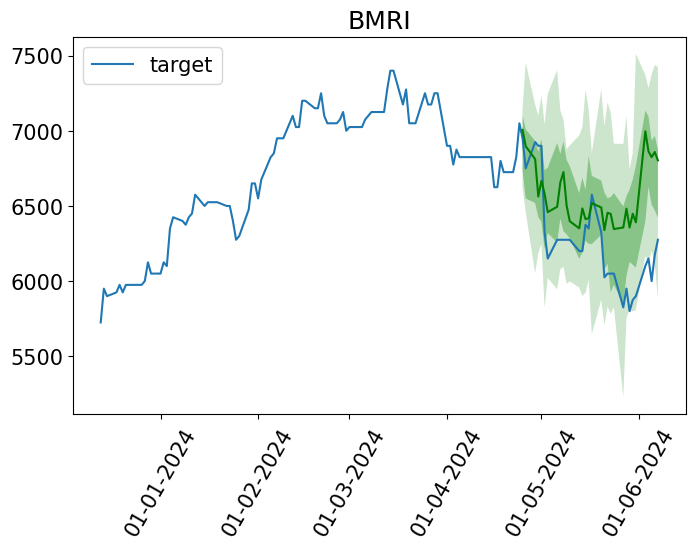

In [20]:
plotting(forecasts_zero_shot_len_32_false, tss_zero_shot_len_32_false)

### Get predictions with the default context length ***(64)***

In [21]:
forecasts_zero_shot_len_64_false, tss_zero_shot_len_64_false, agg_metrics = lag_llama_zero_shot(64, False)
zero_shot_len_64_false = print_crps_zero_shot(64, False, agg_metrics)

Running evaluation: 1it [00:00, ?it/s]

Lag-Llama Zero-Shot (64) rope_scaled (False) CRPS: 0.0445


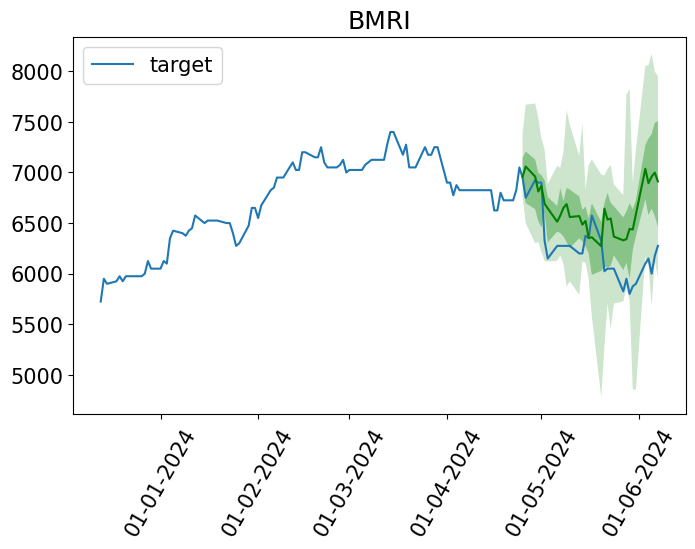

In [22]:
plotting(forecasts_zero_shot_len_64_false, tss_zero_shot_len_64_false)

Now enable **RoPE scaling** which better equips the model in handling large context lengths (larger than 32 in this case). This is done by passing `use_rope_scaling=True` to the `get_lag_llama_predictions` function.

In [23]:
forecasts_zero_shot_len_64_true, tss_zero_shot_len_64_true, agg_metrics = lag_llama_zero_shot(64, True)
zero_shot_len_64_true = print_crps_zero_shot(64, True, agg_metrics)

Running evaluation: 1it [00:00, ?it/s]

Lag-Llama Zero-Shot (64) rope_scaled (True) CRPS: 0.0544


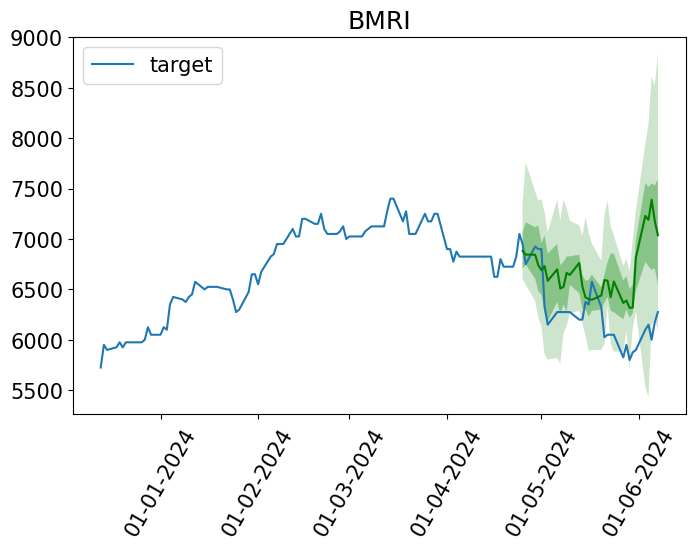

In [24]:
plotting(forecasts_zero_shot_len_64_true, tss_zero_shot_len_64_true)

### Get predictions with the default context length ***(128)***

In [25]:
forecasts_zero_shot_len_128_true, tss_zero_shot_len_128_true, agg_metrics = lag_llama_zero_shot(128, True)
zero_shot_len_128_true = print_crps_zero_shot(128, True, agg_metrics)

Running evaluation: 1it [00:00, ?it/s]

Lag-Llama Zero-Shot (128) rope_scaled (True) CRPS: 0.0377


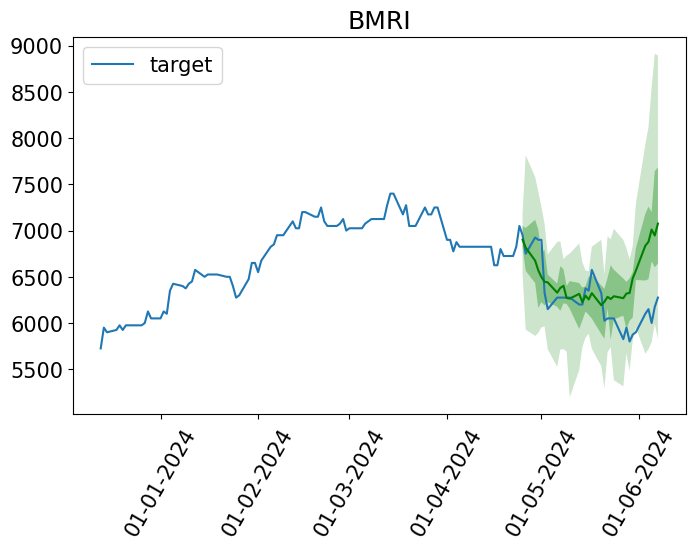

In [26]:
plotting(forecasts_zero_shot_len_128_true, tss_zero_shot_len_128_true)

### Get predictions with the default context length ***(256)***

In [27]:
forecasts_zero_shot_len_256_true, tss_zero_shot_len_256_true, agg_metrics = lag_llama_zero_shot(256, True)
zero_shot_len_256_true = print_crps_zero_shot(256, True, agg_metrics)

Running evaluation: 1it [00:00, 199.83it/s]

Lag-Llama Zero-Shot (256) rope_scaled (True) CRPS: 0.0466


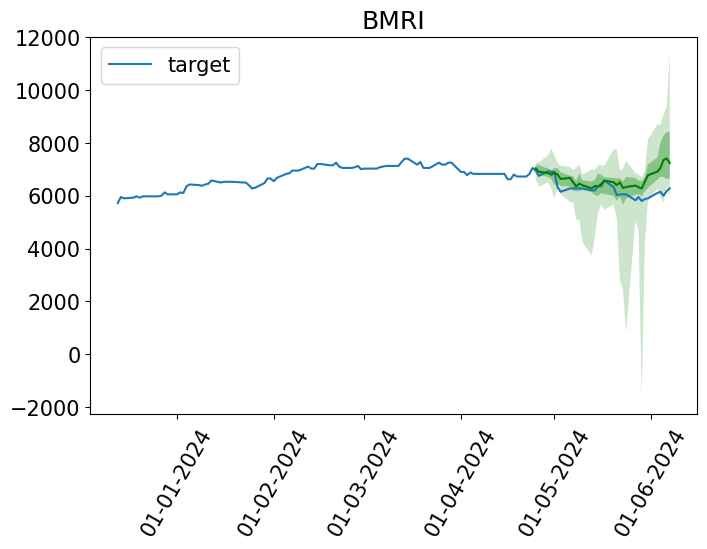

In [28]:
plotting(forecasts_zero_shot_len_256_true, tss_zero_shot_len_256_true)

### Get predictions with the default context length ***(512)***

In [29]:
forecasts_zero_shot_len_512_true, tss_zero_shot_len_512_true, agg_metrics = lag_llama_zero_shot(512, True)
zero_shot_len_512_true = print_crps_zero_shot(512, True, agg_metrics)

Running evaluation: 1it [00:00, 249.82it/s]

Lag-Llama Zero-Shot (512) rope_scaled (True) CRPS: 0.1305


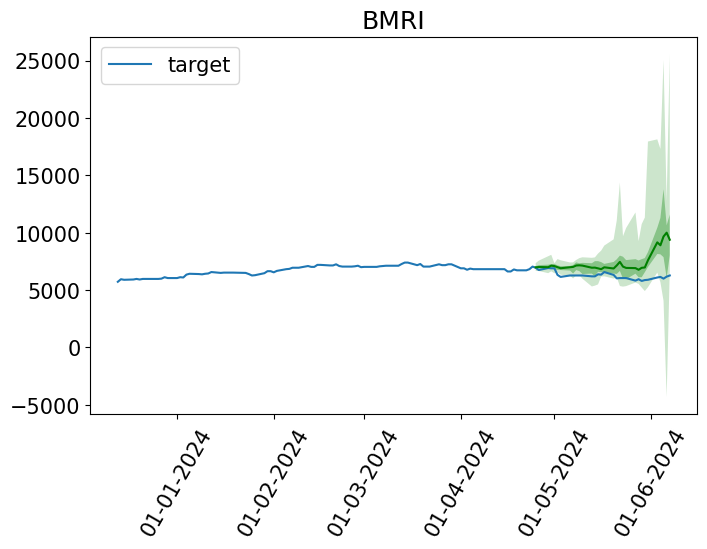

In [30]:
plotting(forecasts_zero_shot_len_512_true, tss_zero_shot_len_512_true)

### Get predictions with the default context length ***(1024)***

In [31]:
forecasts_zero_shot_len_1024_true, tss_zero_shot_len_1024_true, agg_metrics = lag_llama_zero_shot(1024, True)
zero_shot_len_1024_true = print_crps_zero_shot(1024, True, agg_metrics)

Running evaluation: 1it [00:00, ?it/s]

Lag-Llama Zero-Shot (1024) rope_scaled (True) CRPS: 0.1966


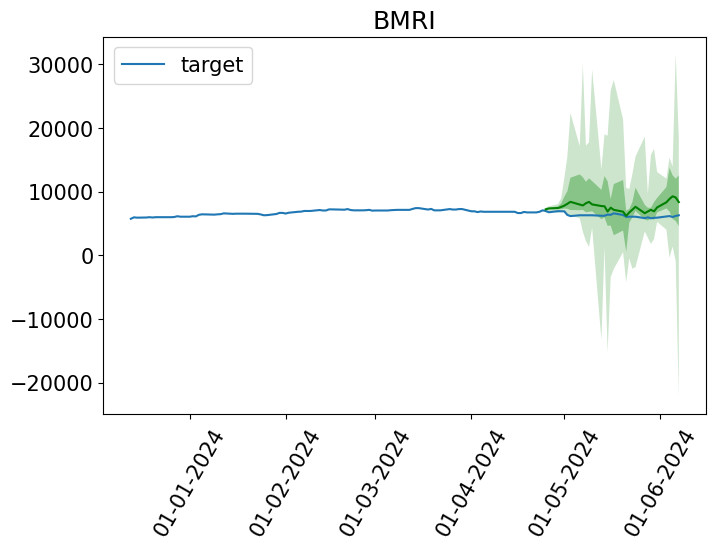

In [32]:
plotting(forecasts_zero_shot_len_1024_true, tss_zero_shot_len_1024_true)

# **Lag-Llama Fine-Tuning**

### ***Learning Rate 1e-2***

### Get predictions with the default context length ***(32)***

In [33]:
forecasts_fine_tuning_len_32_lr_1e_2, tss_fine_tuning_len_32_lr_1e_2, agg_metrics = lag_llama_fine_tuning(32, 1e-2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 11.41884 (best 11.41884), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_497\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 9.08064 (best 9.08064), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_497\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.69100 (best 8.69100), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_497\\checkpoints\\epoch=2-step=150-v1.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 8.49739 (best 8.49739), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_497\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 8.49439 (best 8.49439), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_

In [34]:
fine_tuning_len_32_lr_1e_2 = print_crps_fine_tuning(32, 1e-2, agg_metrics)

Lag-Llama Fine-Tuning (32) Lr 0.01 CRPS: 0.0930


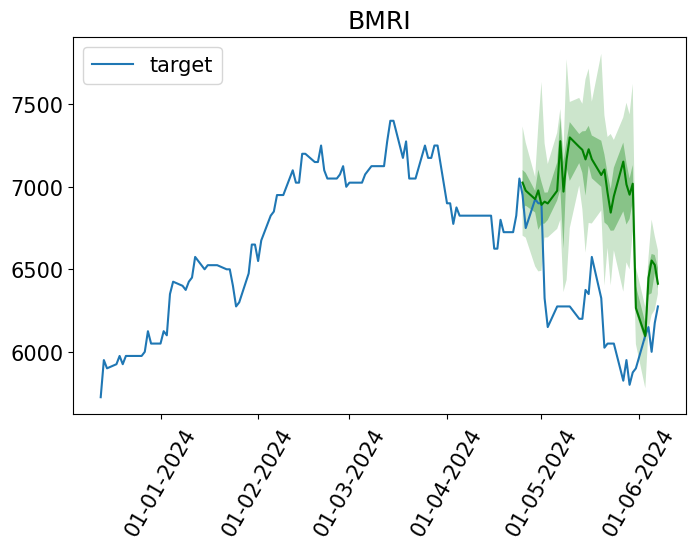

In [35]:
plotting(forecasts_fine_tuning_len_32_lr_1e_2, tss_fine_tuning_len_32_lr_1e_2)

### Get predictions with the default context length ***(64)***

In [36]:
forecasts_fine_tuning_len_64_lr_1e_2, tss_fine_tuning_len_64_lr_1e_2, agg_metrics = lag_llama_fine_tuning(64, 1e-2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 11.09844 (best 11.09844), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_499\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.75298 (best 8.75298), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_499\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.55425 (best 8.55425), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_499\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 8.42264 (best 8.42264), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_499\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 8.03698 (best 8.03698), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_log

In [37]:
fine_tuning_len_64_lr_1e_2 = print_crps_fine_tuning(64, 1e-2, agg_metrics)

Lag-Llama Fine-Tuning (64) Lr 0.01 CRPS: 0.0879


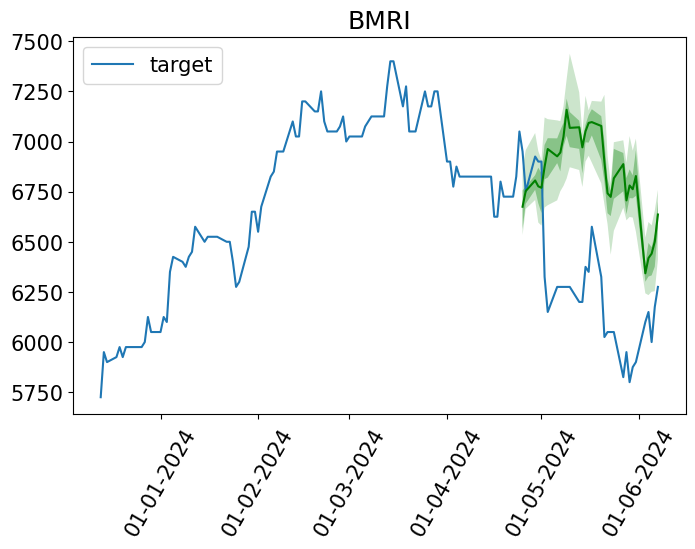

In [38]:
plotting(forecasts_fine_tuning_len_64_lr_1e_2, tss_fine_tuning_len_64_lr_1e_2)

### Get predictions with the default context length ***(128)***

In [39]:
forecasts_fine_tuning_len_128_lr_1e_2, tss_fine_tuning_len_128_lr_1e_2, agg_metrics = lag_llama_fine_tuning(128, 1e-2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 10.56901 (best 10.56901), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_501\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.76892 (best 8.76892), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_501\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.44920 (best 8.44920), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_501\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 8.32030 (best 8.32030), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_501\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 8.30589 (best 8.30589), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_501\\checkpoints\\epoch=4-step=250.ckpt' as t

In [40]:
fine_tuning_len_128_lr_1e_2 = print_crps_fine_tuning(128, 1e-2, agg_metrics)

Lag-Llama Fine-Tuning (128) Lr 0.01 CRPS: 0.0637


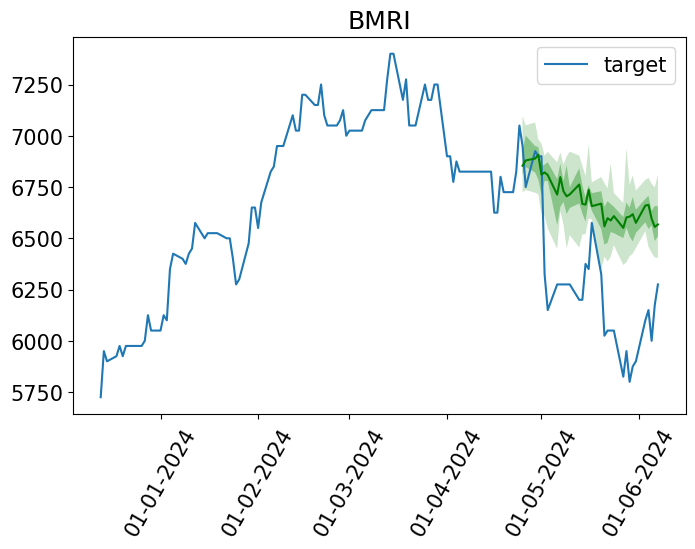

In [41]:
plotting(forecasts_fine_tuning_len_128_lr_1e_2, tss_fine_tuning_len_128_lr_1e_2)

### Get predictions with the default context length ***(256)***

In [42]:
forecasts_fine_tuning_len_256_lr_1e_2, tss_fine_tuning_len_256_lr_1e_2, agg_metrics = lag_llama_fine_tuning(256, 1e-2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.97007 (best 9.97007), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_503\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.46757 (best 8.46757), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_503\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 8.24435 (best 8.24435), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_503\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 8.17343 (best 8.17343), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_503\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' reached 7.79854 (best 7.79854), saving model to

In [43]:
fine_tuning_len_256_lr_1e_2 = print_crps_fine_tuning(256, 1e-2, agg_metrics)

Lag-Llama Fine-Tuning (256) Lr 0.01 CRPS: 0.0431


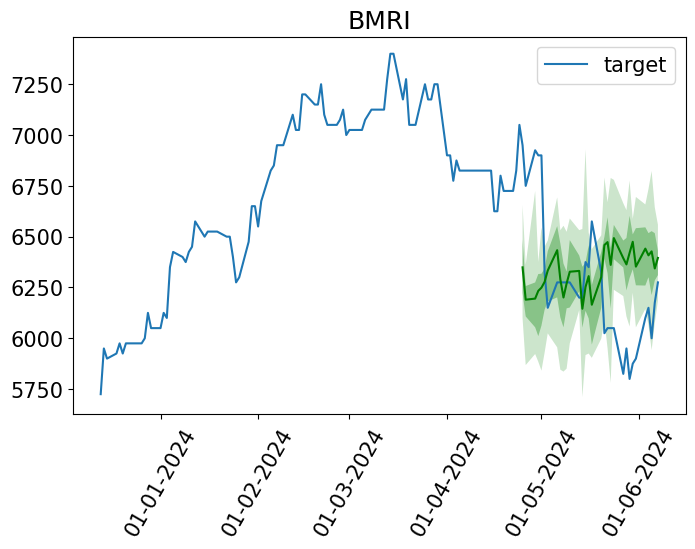

In [44]:
plotting(forecasts_fine_tuning_len_256_lr_1e_2, tss_fine_tuning_len_256_lr_1e_2)

### Get predictions with the default context length ***(512)***

In [45]:
forecasts_fine_tuning_len_512_lr_1e_2, tss_fine_tuning_len_512_lr_1e_2, agg_metrics = lag_llama_fine_tuning(512, 1e-2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.87888 (best 9.87888), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_505\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.62063 (best 8.62063), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_505\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.41990 (best 8.41990), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_505\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 8.26459 (best 8.26459), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_505\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 8.10923 (best 8.10923), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_505\\checkpoints\\epoch=4-step=250.ckpt' as top

In [46]:
fine_tuning_len_512_lr_1e_2 = print_crps_fine_tuning(512, 1e-2, agg_metrics)

Lag-Llama Fine-Tuning (512) Lr 0.01 CRPS: 0.0461


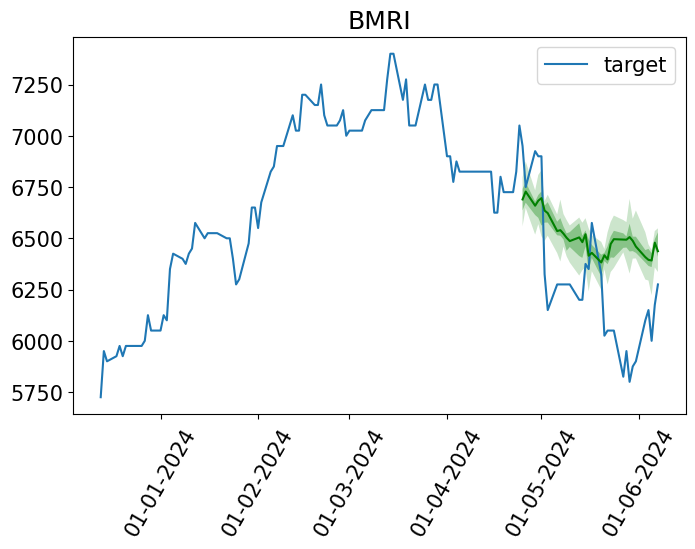

In [47]:
plotting(forecasts_fine_tuning_len_512_lr_1e_2, tss_fine_tuning_len_512_lr_1e_2)

### Get predictions with the default context length ***(1024)***

In [48]:
forecasts_fine_tuning_len_1024_lr_1e_2, tss_fine_tuning_len_1024_lr_1e_2, agg_metrics = lag_llama_fine_tuning(1024, 1e-2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.97601 (best 8.97601), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_506\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.54933 (best 8.54933), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_506\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 8.38502 (best 8.38502), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_506\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' reached 8.38470 (best 8.38470), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_506\\checkpoints\\epoch=6-step=350.ckpt' as top 1
Epoch 7, global step 400: 'tra

In [49]:
fine_tuning_len_1024_lr_1e_2 = print_crps_fine_tuning(1024, 1e-2, agg_metrics)

Lag-Llama Fine-Tuning (1024) Lr 0.01 CRPS: 0.0536


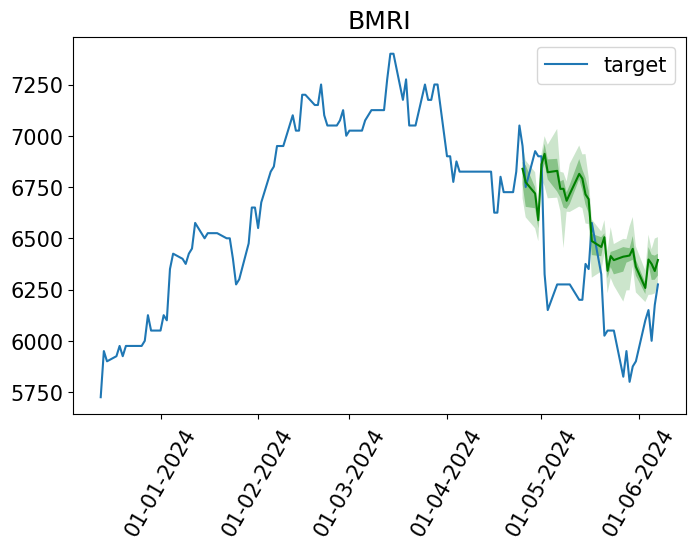

In [50]:
plotting(forecasts_fine_tuning_len_1024_lr_1e_2, tss_fine_tuning_len_1024_lr_1e_2)

### ***Learning Rate 1e-3***

### Get predictions with the default context length ***(32)***

In [51]:
forecasts_fine_tuning_len_32_lr_1e_3, tss_fine_tuning_len_32_lr_1e_3, agg_metrics = lag_llama_fine_tuning(32, 1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.74511 (best 9.74511), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_508\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.02486 (best 8.02486), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_508\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.86171 (best 7.86171), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_508\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 7.81708 (best 7.81708), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_508\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 7.35234 (best 7.35234), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [52]:
fine_tuning_len_32_lr_1e_3 = print_crps_fine_tuning(32, 1e-3, agg_metrics)

Lag-Llama Fine-Tuning (32) Lr 0.001 CRPS: 0.0880


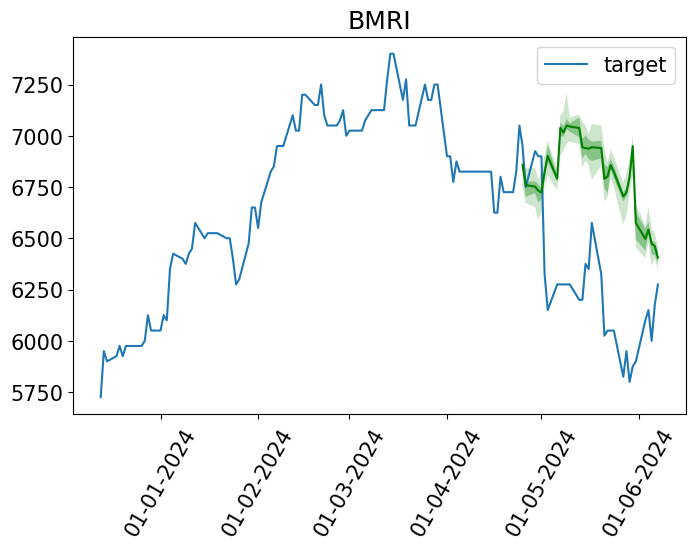

In [53]:
plotting(forecasts_fine_tuning_len_32_lr_1e_3, tss_fine_tuning_len_32_lr_1e_3)

### Get predictions with the default context length ***(64)***

In [54]:
forecasts_fine_tuning_len_64_lr_1e_3, tss_fine_tuning_len_64_lr_1e_3, agg_metrics = lag_llama_fine_tuning(64, 1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.63296 (best 9.63296), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_510\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.18505 (best 8.18505), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_510\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.70683 (best 7.70683), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_510\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.57427 (best 7.57427), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_510\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.55681 (best 7.55681), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_510\\checkpoints\\epoch=4-step=250.ckpt' as top

In [55]:
fine_tuning_len_64_lr_1e_3 = print_crps_fine_tuning(64, 1e-3, agg_metrics)

Lag-Llama Fine-Tuning (64) Lr 0.001 CRPS: 0.1481


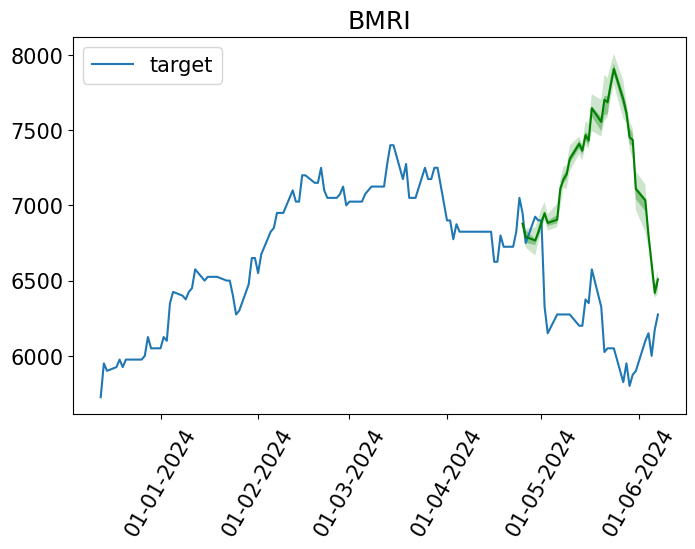

In [56]:
plotting(forecasts_fine_tuning_len_64_lr_1e_3, tss_fine_tuning_len_64_lr_1e_3)

### Get predictions with the default context length ***(128)***

In [57]:
forecasts_fine_tuning_len_128_lr_1e_3, tss_fine_tuning_len_128_lr_1e_3, agg_metrics = lag_llama_fine_tuning(128, 1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 10.02804 (best 10.02804), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_512\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.95854 (best 7.95854), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_512\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 7.46566 (best 7.46566), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_512\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.32592 (best 7.32592), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_512\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 7.06651 (best 7.06651), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_log

In [58]:
fine_tuning_len_128_lr_1e_3 = print_crps_fine_tuning(128, 1e-3, agg_metrics)

Lag-Llama Fine-Tuning (128) Lr 0.001 CRPS: 0.1429


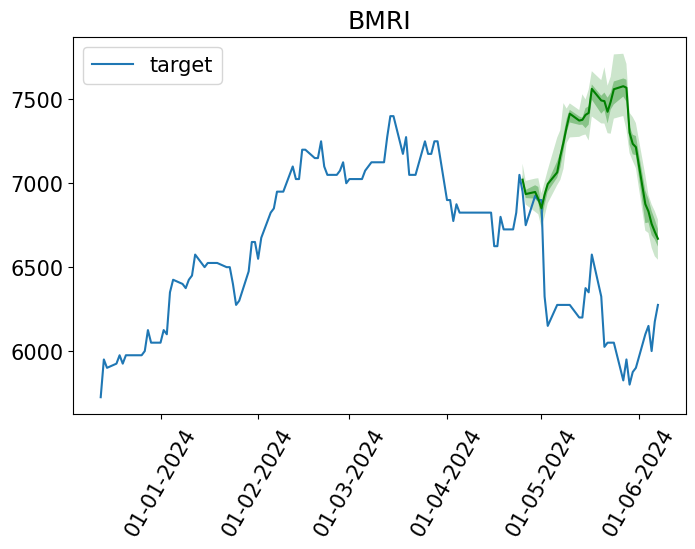

In [59]:
plotting(forecasts_fine_tuning_len_128_lr_1e_3, tss_fine_tuning_len_128_lr_1e_3)

### Get predictions with the default context length ***(256)***

In [60]:
forecasts_fine_tuning_len_256_lr_1e_3, tss_fine_tuning_len_256_lr_1e_3, agg_metrics = lag_llama_fine_tuning(256, 1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 10.83311 (best 10.83311), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_514\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.07656 (best 8.07656), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_514\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.06889 (best 8.06889), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_514\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.42957 (best 7.42957), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_514\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.20658 (best 7.20658), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_514\\checkpoints\\epoch=4-step=250.ckpt' as t

In [61]:
fine_tuning_len_256_lr_1e_3 = print_crps_fine_tuning(256, 1e-3, agg_metrics)

Lag-Llama Fine-Tuning (256) Lr 0.001 CRPS: 0.0467


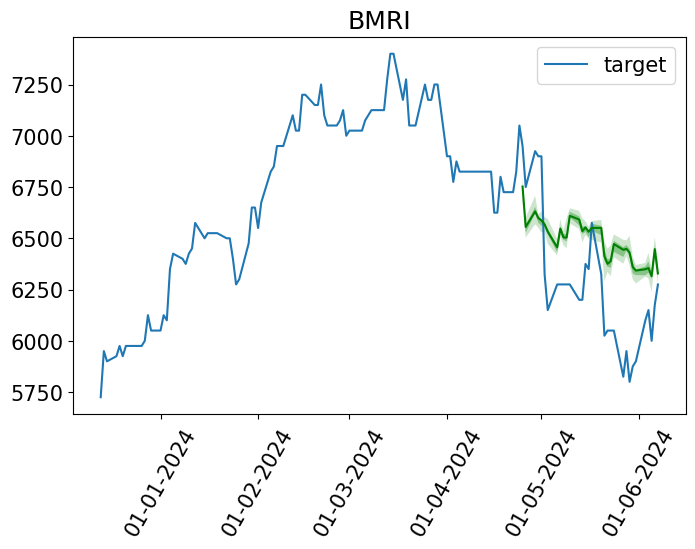

In [62]:
plotting(forecasts_fine_tuning_len_256_lr_1e_3, tss_fine_tuning_len_256_lr_1e_3)

### Get predictions with the default context length ***(512)***

In [63]:
forecasts_fine_tuning_len_512_lr_1e_3, tss_fine_tuning_len_512_lr_1e_3, agg_metrics = lag_llama_fine_tuning(512, 1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.49951 (best 9.49951), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_516\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.81381 (best 7.81381), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_516\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.25511 (best 7.25511), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_516\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.01618 (best 7.01618), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_516\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.77442 (best 6.77442), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_516\\checkpoints\\epoch=4-step=250.ckpt' as top

In [64]:
fine_tuning_len_512_lr_1e_3 = print_crps_fine_tuning(512, 1e-3, agg_metrics)

Lag-Llama Fine-Tuning (512) Lr 0.001 CRPS: 0.0898


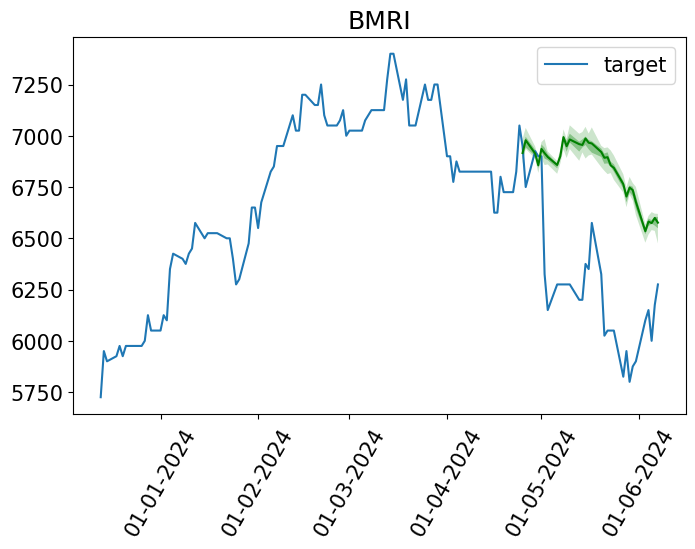

In [65]:
plotting(forecasts_fine_tuning_len_512_lr_1e_3, tss_fine_tuning_len_512_lr_1e_3)

### Get predictions with the default context length ***(1024)***

In [66]:
forecasts_fine_tuning_len_1024_lr_1e_3, tss_fine_tuning_len_1024_lr_1e_3, agg_metrics = lag_llama_fine_tuning(1024, 1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.94968 (best 8.94968), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_518\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.97491 (best 7.97491), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_518\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.34310 (best 7.34310), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_518\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.88379 (best 6.88379), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_518\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 6.64497 (best 6.64497), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [67]:
fine_tuning_len_1024_lr_1e_3 = print_crps_fine_tuning(1024, 1e-3, agg_metrics)

Lag-Llama Fine-Tuning (1024) Lr 0.001 CRPS: 0.0696


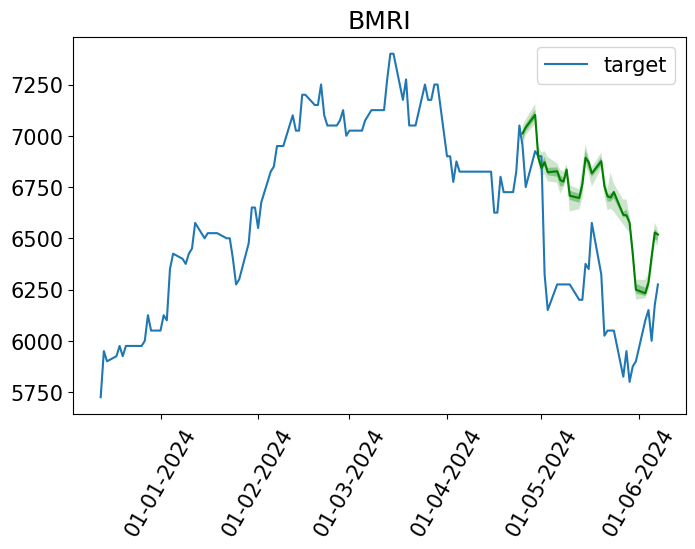

In [68]:
plotting(forecasts_fine_tuning_len_1024_lr_1e_3, tss_fine_tuning_len_1024_lr_1e_3)

### ***Learning Rate 1e-4***

### Get predictions with the default context length ***(32)***

In [69]:
forecasts_fine_tuning_len_32_lr_1e_4, tss_fine_tuning_len_32_lr_1e_4, agg_metrics = lag_llama_fine_tuning(32, 1e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.31924 (best 7.31924), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_520\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.38459 (best 6.38459), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_520\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.33095 (best 6.33095), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_520\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.28861 (best 6.28861), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_520\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.28595 (best 6.28595), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_520\\checkpoints\\epoch=4-step=250.ckpt' as top

In [70]:
fine_tuning_len_32_lr_1e_4 = print_crps_fine_tuning(32, 1e-4, agg_metrics)

Lag-Llama Fine-Tuning (32) Lr 0.0001 CRPS: 0.0676


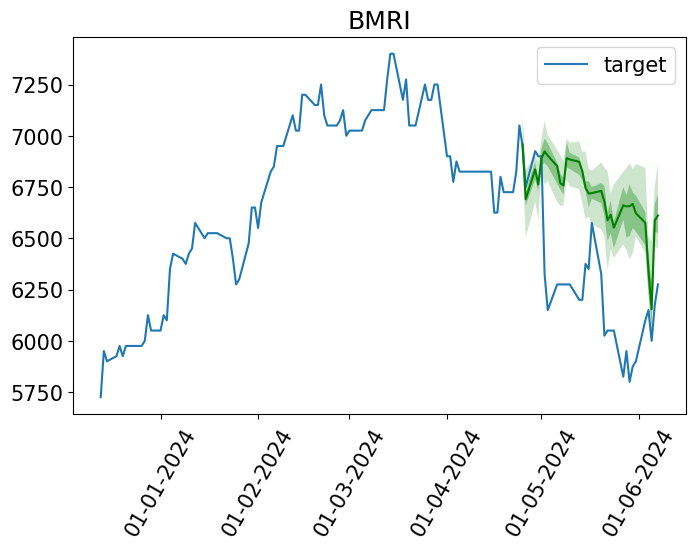

In [71]:
plotting(forecasts_fine_tuning_len_32_lr_1e_4, tss_fine_tuning_len_32_lr_1e_4)

### Get predictions with the default context length ***(64)***

In [72]:
forecasts_fine_tuning_len_64_lr_1e_4, tss_fine_tuning_len_64_lr_1e_4, agg_metrics = lag_llama_fine_tuning(64, 1e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.24783 (best 7.24783), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_522\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.36025 (best 6.36025), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_522\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.33149 (best 6.33149), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_522\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.26256 (best 6.26256), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_522\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 6.22995 (best 6.22995), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [73]:
fine_tuning_len_64_lr_1e_4 = print_crps_fine_tuning(64, 1e-4, agg_metrics)

Lag-Llama Fine-Tuning (64) Lr 0.0001 CRPS: 0.1416


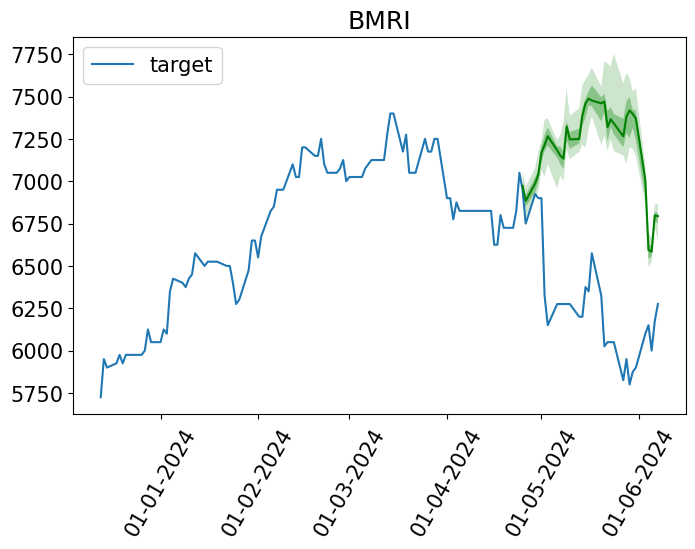

In [74]:
plotting(forecasts_fine_tuning_len_64_lr_1e_4, tss_fine_tuning_len_64_lr_1e_4)

### Get predictions with the default context length ***(128)***

In [75]:
forecasts_fine_tuning_len_128_lr_1e_4, tss_fine_tuning_len_128_lr_1e_4, agg_metrics = lag_llama_fine_tuning(128, 1e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.23225 (best 7.23225), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_524\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.36519 (best 6.36519), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_524\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.29605 (best 6.29605), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_524\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 6.24217 (best 6.24217), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_524\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 6.22700 (best 6.22700), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [76]:
fine_tuning_len_128_lr_1e_4 = print_crps_fine_tuning(128, 1e-4, agg_metrics)

Lag-Llama Fine-Tuning (128) Lr 0.0001 CRPS: 0.1285


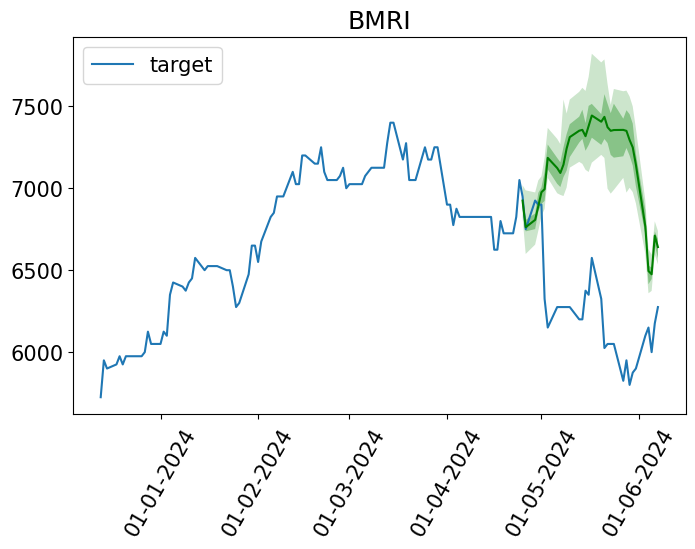

In [77]:
plotting(forecasts_fine_tuning_len_128_lr_1e_4, tss_fine_tuning_len_128_lr_1e_4)

### Get predictions with the default context length ***(256)***

In [78]:
forecasts_fine_tuning_len_256_lr_1e_4, tss_fine_tuning_len_256_lr_1e_4, agg_metrics = lag_llama_fine_tuning(256, 1e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.07284 (best 7.07284), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_526\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.40278 (best 6.40278), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_526\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.27053 (best 6.27053), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_526\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.26378 (best 6.26378), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_526\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.24048 (best 6.24048), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_526\\checkpoints\\epoch=4-step=250.ckpt' as top

In [79]:
fine_tuning_len_256_lr_1e_4 = print_crps_fine_tuning(256, 1e-4, agg_metrics)

Lag-Llama Fine-Tuning (256) Lr 0.0001 CRPS: 0.0371


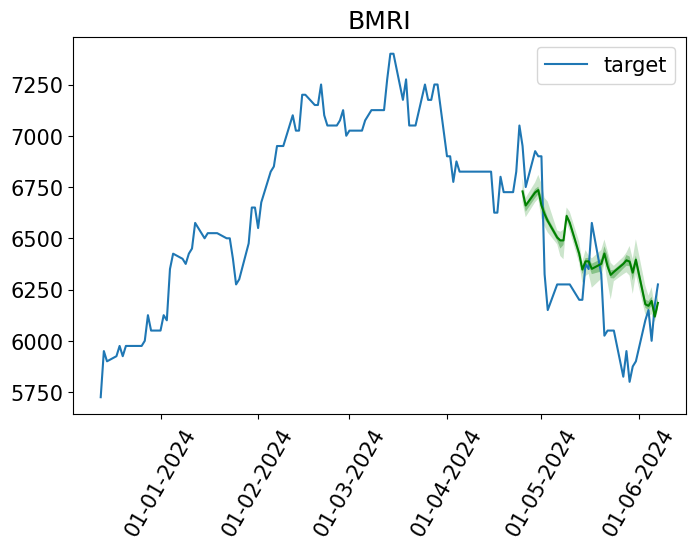

In [80]:
plotting(forecasts_fine_tuning_len_256_lr_1e_4, tss_fine_tuning_len_256_lr_1e_4)

### Get predictions with the default context length ***(512)***

In [81]:
forecasts_fine_tuning_len_512_lr_1e_4, tss_fine_tuning_len_512_lr_1e_4, agg_metrics = lag_llama_fine_tuning(512, 1e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.86537 (best 6.86537), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_528\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.35804 (best 6.35804), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_528\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.31820 (best 6.31820), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_528\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.26187 (best 6.26187), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_528\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.21721 (best 6.21721), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_528\\checkpoints\\epoch=4-step=250.ckpt' as top

In [82]:
fine_tuning_len_512_lr_1e_4 = print_crps_fine_tuning(512, 1e-4, agg_metrics)

Lag-Llama Fine-Tuning (512) Lr 0.0001 CRPS: 0.0887


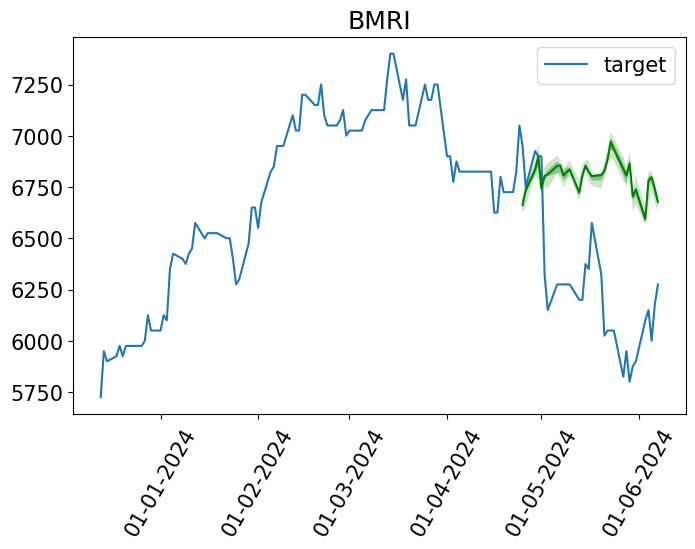

In [83]:
plotting(forecasts_fine_tuning_len_512_lr_1e_4, tss_fine_tuning_len_512_lr_1e_4)

### Get predictions with the default context length ***(1024)***

In [84]:
forecasts_fine_tuning_len_1024_lr_1e_4, tss_fine_tuning_len_1024_lr_1e_4, agg_metrics = lag_llama_fine_tuning(1024, 1e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.92180 (best 6.92180), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_530\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.44717 (best 6.44717), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_530\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.32332 (best 6.32332), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_530\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.29977 (best 6.29977), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_530\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.26765 (best 6.26765), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_530\\checkpoints\\epoch=4-step=250.ckpt' as top

In [85]:
fine_tuning_len_1024_lr_1e_4 = print_crps_fine_tuning(1024, 1e-4, agg_metrics)

Lag-Llama Fine-Tuning (1024) Lr 0.0001 CRPS: 0.0665


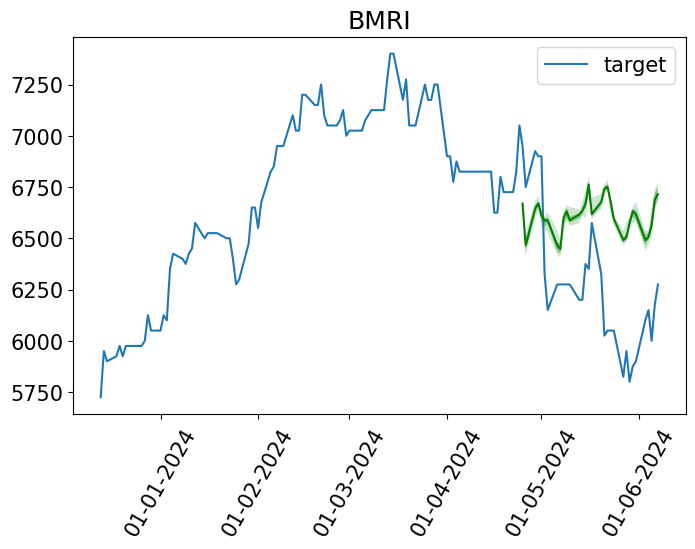

In [86]:
plotting(forecasts_fine_tuning_len_1024_lr_1e_4, tss_fine_tuning_len_1024_lr_1e_4)

### ***Learning Rate 5e-3***

### Get predictions with the default context length ***(32)***

In [87]:
forecasts_fine_tuning_len_32_lr_5e_3, tss_fine_tuning_len_32_lr_5e_3, agg_metrics = lag_llama_fine_tuning(32, 5e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.86689 (best 9.86689), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_532\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.59486 (best 8.59486), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_532\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.55064 (best 8.55064), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_532\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 8.29678 (best 8.29678), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_532\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 8.01295 (best 8.01295), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_532\\checkpoints\\epoch=4-step=250.ckpt' as top

In [88]:
fine_tuning_len_32_lr_5e_3 = print_crps_fine_tuning(32, 5e-3, agg_metrics)

Lag-Llama Fine-Tuning (32) Lr 0.005 CRPS: 0.0699


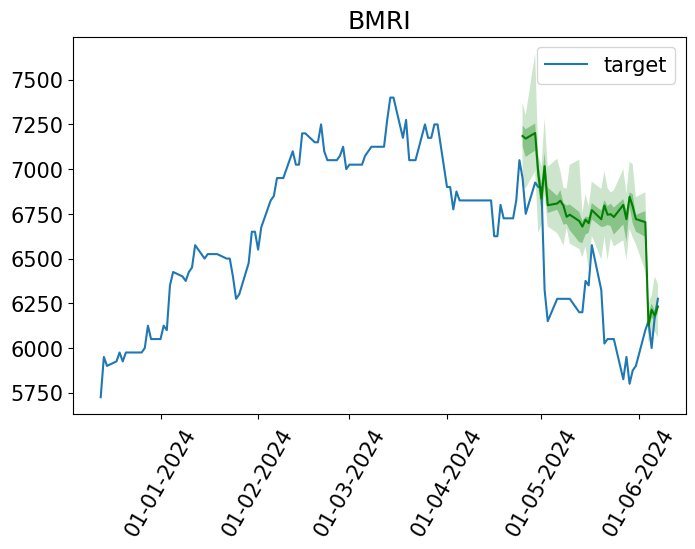

In [89]:
plotting(forecasts_fine_tuning_len_32_lr_5e_3, tss_fine_tuning_len_32_lr_5e_3)

### Get predictions with the default context length ***(64)***

In [90]:
forecasts_fine_tuning_len_64_lr_5e_3, tss_fine_tuning_len_64_lr_5e_3, agg_metrics = lag_llama_fine_tuning(64, 5e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.76206 (best 9.76206), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_534\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.53067 (best 8.53067), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_534\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.29019 (best 8.29019), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_534\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 7.93676 (best 7.93676), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_534\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 7.72951 (best 7.72951), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [91]:
fine_tuning_len_64_lr_5e_3 = print_crps_fine_tuning(64, 5e-3, agg_metrics)

Lag-Llama Fine-Tuning (64) Lr 0.005 CRPS: 0.0664


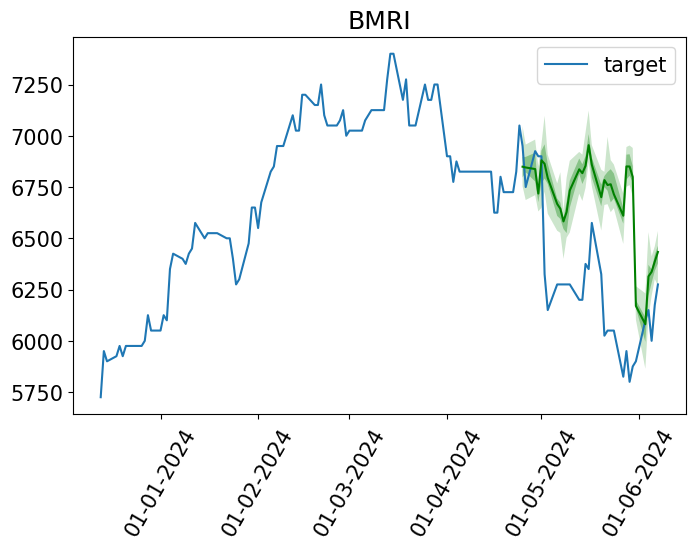

In [92]:
plotting(forecasts_fine_tuning_len_64_lr_5e_3, tss_fine_tuning_len_64_lr_5e_3)

### Get predictions with the default context length ***(128)***

In [93]:
forecasts_fine_tuning_len_128_lr_5e_3, tss_fine_tuning_len_128_lr_5e_3, agg_metrics = lag_llama_fine_tuning(128, 5e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.89515 (best 9.89515), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_536\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.38560 (best 8.38560), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_536\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 8.33111 (best 8.33111), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_536\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.99904 (best 7.99904), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_536\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' reached 7.74270 (best 7.74270), saving model to

In [94]:
fine_tuning_len_128_lr_5e_3 = print_crps_fine_tuning(128, 5e-3, agg_metrics)

Lag-Llama Fine-Tuning (128) Lr 0.005 CRPS: 0.0582


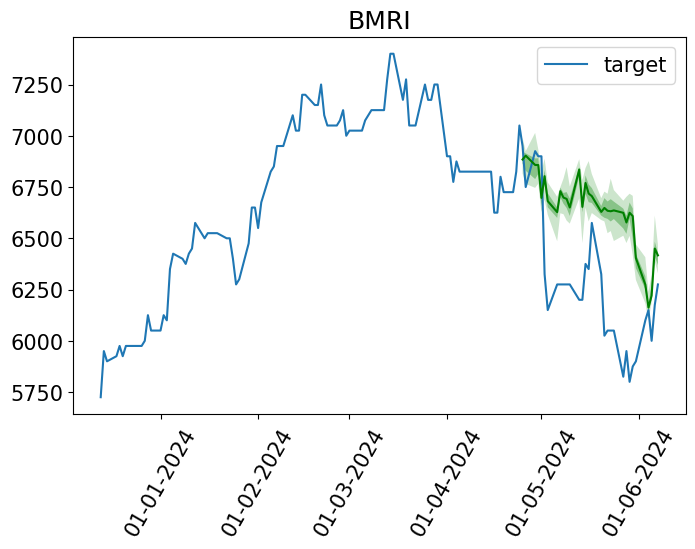

In [95]:
plotting(forecasts_fine_tuning_len_128_lr_5e_3, tss_fine_tuning_len_128_lr_5e_3)

### Get predictions with the default context length ***(256)***

In [96]:
forecasts_fine_tuning_len_256_lr_5e_3, tss_fine_tuning_len_256_lr_5e_3, agg_metrics = lag_llama_fine_tuning(256, 5e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.82460 (best 9.82460), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_538\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.36664 (best 8.36664), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_538\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.36217 (best 8.36217), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_538\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 8.19520 (best 8.19520), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_538\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 7.86068 (best 7.86068), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [97]:
fine_tuning_len_256_lr_5e_3 = print_crps_fine_tuning(256, 5e-3, agg_metrics)

Lag-Llama Fine-Tuning (256) Lr 0.005 CRPS: 0.0469


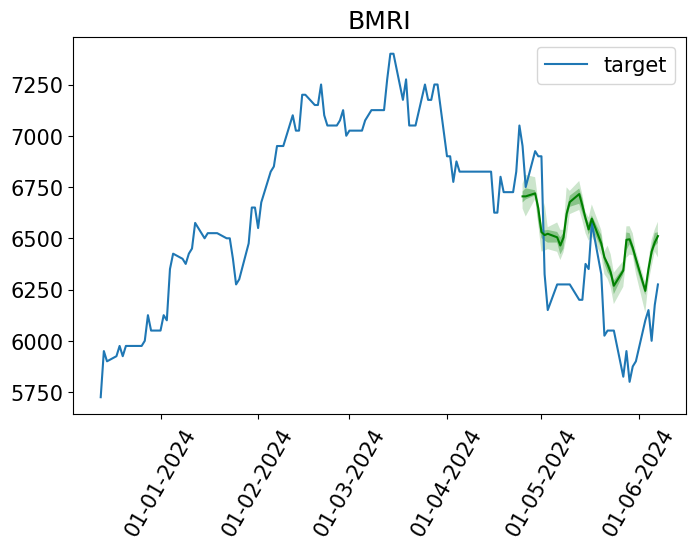

In [98]:
plotting(forecasts_fine_tuning_len_256_lr_5e_3, tss_fine_tuning_len_256_lr_5e_3)

### Get predictions with the default context length ***(512)***

In [99]:
forecasts_fine_tuning_len_512_lr_5e_3, tss_fine_tuning_len_512_lr_5e_3, agg_metrics = lag_llama_fine_tuning(512, 5e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 10.32350 (best 10.32350), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_540\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.33982 (best 8.33982), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_540\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 7.79897 (best 7.79897), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_540\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.72346 (best 7.72346), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_540\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 7.29019 (best 7.29019), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_log

In [100]:
fine_tuning_len_512_lr_5e_3 = print_crps_fine_tuning(512, 5e-3, agg_metrics)

Lag-Llama Fine-Tuning (512) Lr 0.005 CRPS: 0.0439


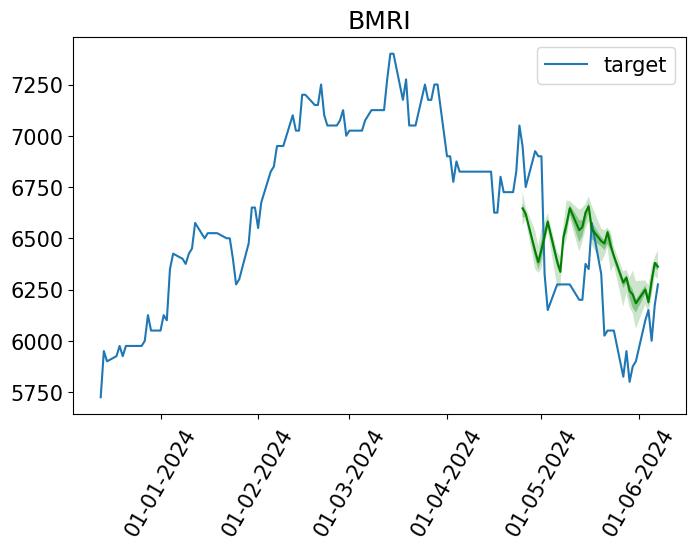

In [101]:
plotting(forecasts_fine_tuning_len_512_lr_5e_3, tss_fine_tuning_len_512_lr_5e_3)

### Get predictions with the default context length ***(1024)***

In [102]:
forecasts_fine_tuning_len_1024_lr_5e_3, tss_fine_tuning_len_1024_lr_5e_3, agg_metrics = lag_llama_fine_tuning(1024, 5e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.23566 (best 9.23566), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_542\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 8.53947 (best 8.53947), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_542\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 8.13317 (best 8.13317), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_542\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.99828 (best 7.99828), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_542\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.77039 (best 7.77039), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_542\\checkpoints\\epoch=4-step=250.ckpt' as top

In [103]:
fine_tuning_len_1024_lr_5e_3 = print_crps_fine_tuning(1024, 5e-3, agg_metrics)

Lag-Llama Fine-Tuning (1024) Lr 0.005 CRPS: 0.0585


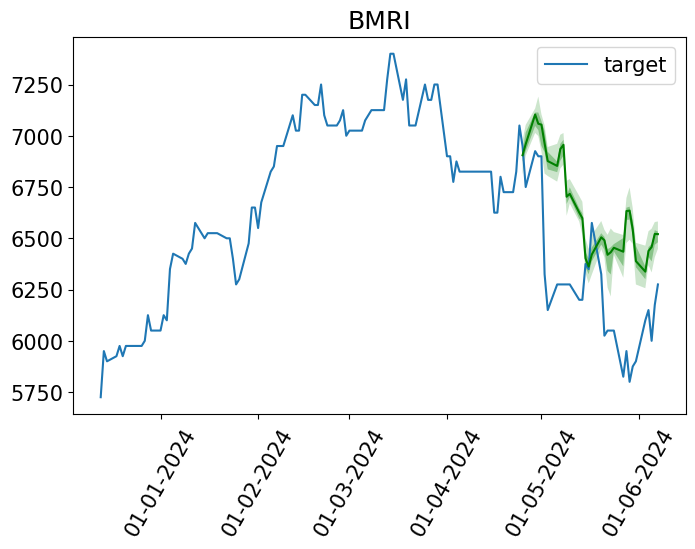

In [104]:
plotting(forecasts_fine_tuning_len_1024_lr_5e_3, tss_fine_tuning_len_1024_lr_5e_3)

### ***Learning Rate 5e-4***

### Get predictions with the default context length ***(32)***

In [105]:
forecasts_fine_tuning_len_32_lr_5e_4, tss_fine_tuning_len_32_lr_5e_4, agg_metrics = lag_llama_fine_tuning(32, 5e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.79793 (best 8.79793), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_544\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.73267 (best 7.73267), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_544\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.25790 (best 7.25790), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_544\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.95163 (best 6.95163), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_544\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 6.84158 (best 6.84158), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [106]:
fine_tuning_len_32_lr_5e_4 = print_crps_fine_tuning(32, 5e-4, agg_metrics)

Lag-Llama Fine-Tuning (32) Lr 0.0005 CRPS: 0.1264


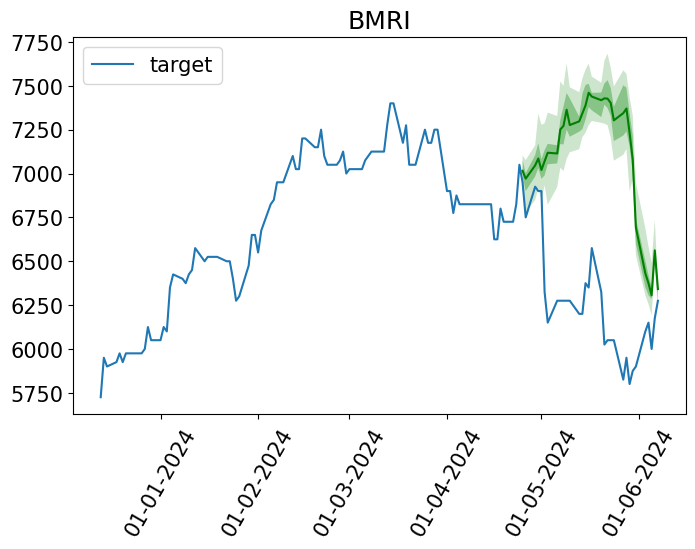

In [107]:
plotting(forecasts_fine_tuning_len_32_lr_5e_4, tss_fine_tuning_len_32_lr_5e_4)

### Get predictions with the default context length ***(64)***

In [108]:
forecasts_fine_tuning_len_64_lr_5e_4, tss_fine_tuning_len_64_lr_5e_4, agg_metrics = lag_llama_fine_tuning(64, 5e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.91919 (best 8.91919), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_546\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.69916 (best 7.69916), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_546\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.20100 (best 7.20100), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_546\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 7.06543 (best 7.06543), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_546\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 6.71340 (best 6.71340), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [109]:
fine_tuning_len_64_lr_5e_4 = print_crps_fine_tuning(64, 5e-4, agg_metrics)

Lag-Llama Fine-Tuning (64) Lr 0.0005 CRPS: 0.0765


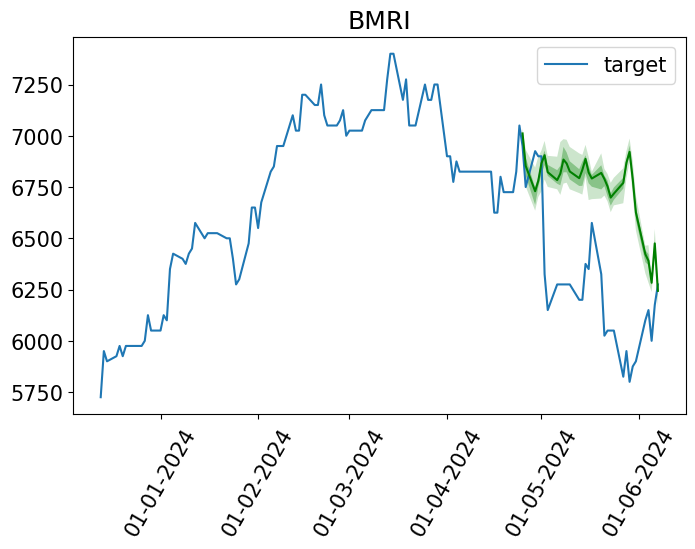

In [110]:
plotting(forecasts_fine_tuning_len_64_lr_5e_4, tss_fine_tuning_len_64_lr_5e_4)

### Get predictions with the default context length ***(128)***

In [111]:
forecasts_fine_tuning_len_128_lr_5e_4, tss_fine_tuning_len_128_lr_5e_4, agg_metrics = lag_llama_fine_tuning(128, 5e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.71063 (best 8.71063), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_548\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.36540 (best 7.36540), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_548\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.29488 (best 7.29488), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_548\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.97778 (best 6.97778), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_548\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.72542 (best 6.72542), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_548\\checkpoints\\epoch=4-step=250.ckpt' as top

In [112]:
fine_tuning_len_128_lr_5e_4 = print_crps_fine_tuning(128, 5e-4, agg_metrics)

Lag-Llama Fine-Tuning (128) Lr 0.0005 CRPS: 0.1204


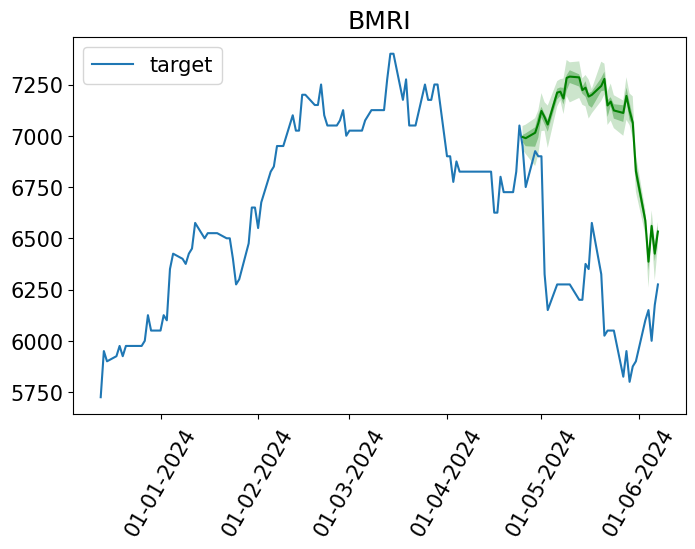

In [113]:
plotting(forecasts_fine_tuning_len_128_lr_5e_4, tss_fine_tuning_len_128_lr_5e_4)

### Get predictions with the default context length ***(256)***

In [114]:
forecasts_fine_tuning_len_256_lr_5e_4, tss_fine_tuning_len_256_lr_5e_4, agg_metrics = lag_llama_fine_tuning(256, 5e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.47099 (best 8.47099), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_550\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.53891 (best 7.53891), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_550\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.32991 (best 7.32991), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_550\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.92533 (best 6.92533), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_550\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.69280 (best 6.69280), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_550\\checkpoints\\epoch=4-step=250.ckpt' as top

In [115]:
fine_tuning_len_256_lr_5e_4 = print_crps_fine_tuning(256, 5e-4, agg_metrics)

Lag-Llama Fine-Tuning (256) Lr 0.0005 CRPS: 0.0757


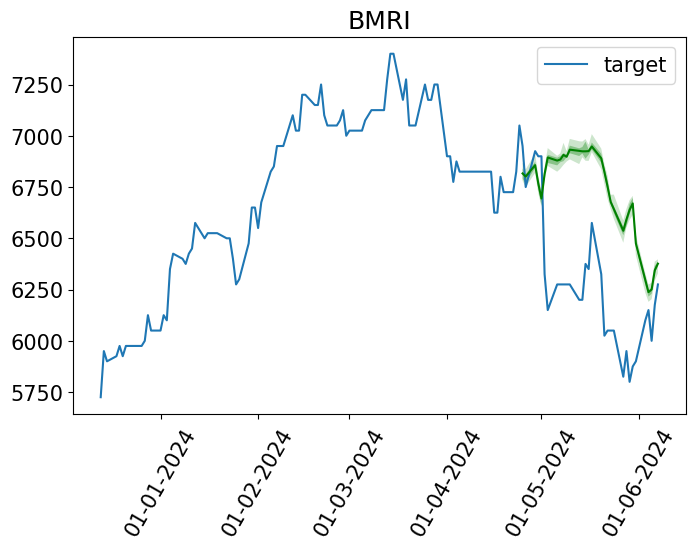

In [116]:
plotting(forecasts_fine_tuning_len_256_lr_5e_4, tss_fine_tuning_len_256_lr_5e_4)

### Get predictions with the default context length ***(512)***

In [117]:
forecasts_fine_tuning_len_512_lr_5e_4, tss_fine_tuning_len_512_lr_5e_4, agg_metrics = lag_llama_fine_tuning(512, 5e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.97129 (best 8.97129), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_552\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.23171 (best 7.23171), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_552\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.19231 (best 7.19231), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_552\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.04156 (best 7.04156), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_552\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.66789 (best 6.66789), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_552\\checkpoints\\epoch=4-step=250.ckpt' as top

In [118]:
fine_tuning_len_512_lr_5e_4 = print_crps_fine_tuning(512, 5e-4, agg_metrics)

Lag-Llama Fine-Tuning (512) Lr 0.0005 CRPS: 0.0585


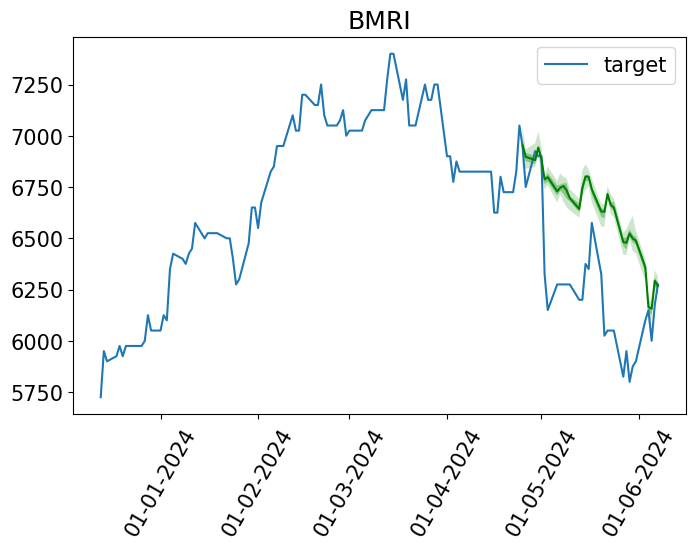

In [119]:
plotting(forecasts_fine_tuning_len_512_lr_5e_4, tss_fine_tuning_len_512_lr_5e_4)

### Get predictions with the default context length ***(1024)***

In [120]:
forecasts_fine_tuning_len_1024_lr_5e_4, tss_fine_tuning_len_1024_lr_5e_4, agg_metrics = lag_llama_fine_tuning(1024, 5e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 8.34660 (best 8.34660), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_554\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.13906 (best 7.13906), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_554\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.78119 (best 6.78119), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_554\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.62308 (best 6.62308), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_554\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' reached 6.33350 (best 6.33350), saving model to

In [121]:
fine_tuning_len_1024_lr_5e_4 = print_crps_fine_tuning(1024, 5e-4, agg_metrics)

Lag-Llama Fine-Tuning (1024) Lr 0.0005 CRPS: 0.0578


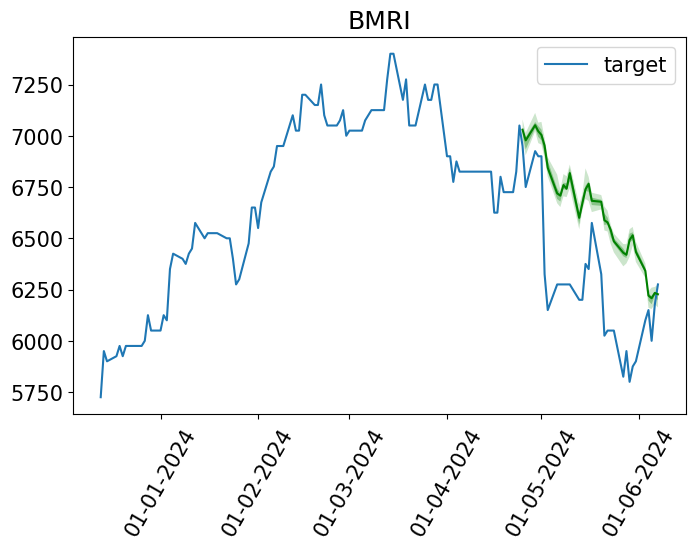

In [122]:
plotting(forecasts_fine_tuning_len_1024_lr_5e_4, tss_fine_tuning_len_1024_lr_5e_4)

### ***Learning Rate 5e-5***

### Get predictions with the default context length ***(32)***

In [123]:
forecasts_fine_tuning_len_32_lr_5e_5, tss_fine_tuning_len_32_lr_5e_5, agg_metrics = lag_llama_fine_tuning(32, 5e-5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.67991 (best 6.67991), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_556\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.28056 (best 6.28056), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_556\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.25863 (best 6.25863), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_556\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.22590 (best 6.22590), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_556\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 6.20479 (best 6.20479), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\

In [124]:
fine_tuning_len_32_lr_5e_5 = print_crps_fine_tuning(32, 5e-5, agg_metrics)

Lag-Llama Fine-Tuning (32) Lr 5e-05 CRPS: 0.0673


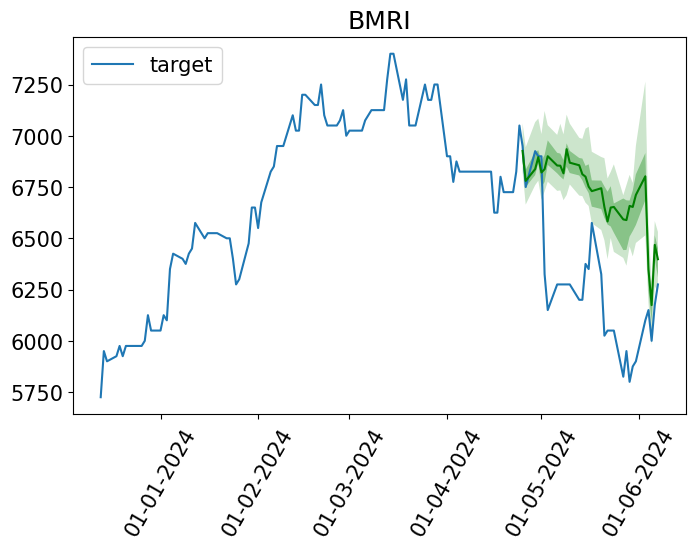

In [125]:
plotting(forecasts_fine_tuning_len_32_lr_5e_5, tss_fine_tuning_len_32_lr_5e_5)

### Get predictions with the default context length ***(64)***

In [126]:
forecasts_fine_tuning_len_64_lr_5e_5, tss_fine_tuning_len_64_lr_5e_5, agg_metrics = lag_llama_fine_tuning(64, 5e-5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.63773 (best 6.63773), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_558\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.28312 (best 6.28312), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_558\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.25765 (best 6.25765), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_558\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.22093 (best 6.22093), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_558\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.21929 (best 6.21929), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_558\\checkpoints\\epoch=4-step=250.ckpt' as top

In [127]:
fine_tuning_len_64_lr_5e_5 = print_crps_fine_tuning(64, 5e-5, agg_metrics)

Lag-Llama Fine-Tuning (64) Lr 5e-05 CRPS: 0.0720


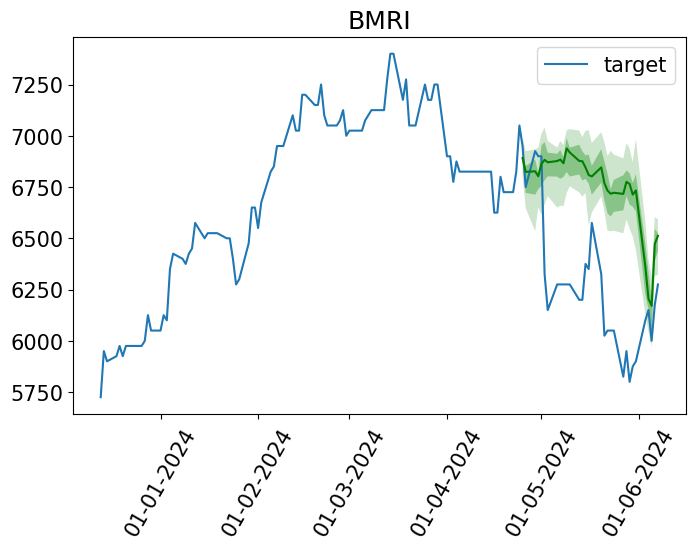

In [128]:
plotting(forecasts_fine_tuning_len_64_lr_5e_5, tss_fine_tuning_len_64_lr_5e_5)

### Get predictions with the default context length ***(128)***

In [129]:
forecasts_fine_tuning_len_128_lr_5e_5, tss_fine_tuning_len_128_lr_5e_5, agg_metrics = lag_llama_fine_tuning(128, 5e-5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.72022 (best 6.72022), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_560\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.28916 (best 6.28916), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_560\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.25450 (best 6.25450), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_560\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.21947 (best 6.21947), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_560\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.19039 (best 6.19039), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_560\\checkpoints\\epoch=4-step=250.ckpt' as top

In [130]:
fine_tuning_len_128_lr_5e_5 = print_crps_fine_tuning(128, 5e-5, agg_metrics)

Lag-Llama Fine-Tuning (128) Lr 5e-05 CRPS: 0.0506


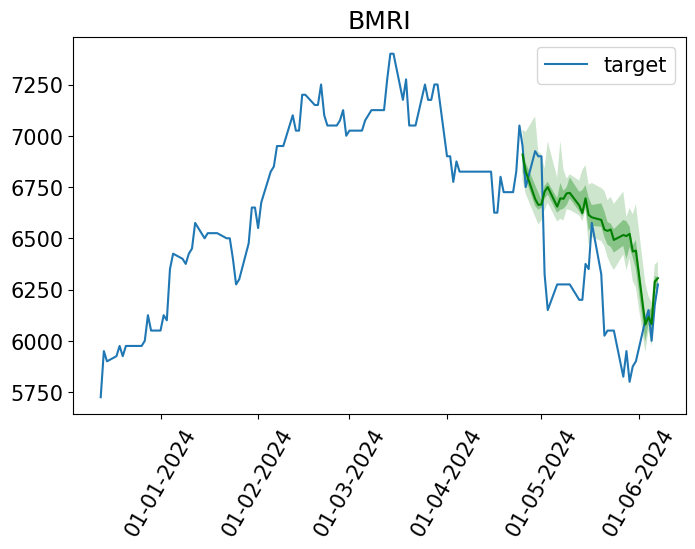

In [131]:
plotting(forecasts_fine_tuning_len_128_lr_5e_5, tss_fine_tuning_len_128_lr_5e_5)

### Get predictions with the default context length ***(256)***

In [132]:
forecasts_fine_tuning_len_256_lr_5e_5, tss_fine_tuning_len_256_lr_5e_5, agg_metrics = lag_llama_fine_tuning(256, 5e-5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.64704 (best 6.64704), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_562\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.29245 (best 6.29245), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_562\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.23014 (best 6.23014), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_562\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.21944 (best 6.21944), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_562\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.20611 (best 6.20611), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_562\\checkpoints\\epoch=4-step=250.ckpt' as top

In [133]:
fine_tuning_len_256_lr_5e_5 = print_crps_fine_tuning(256, 5e-5, agg_metrics)

Lag-Llama Fine-Tuning (256) Lr 5e-05 CRPS: 0.0705


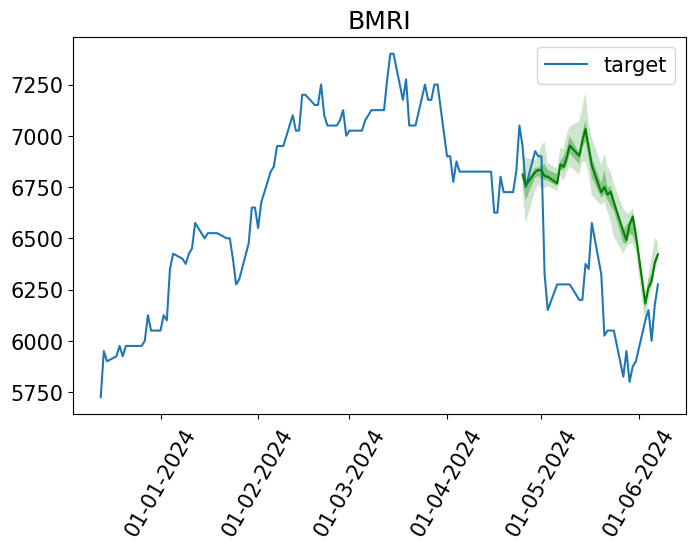

In [134]:
plotting(forecasts_fine_tuning_len_256_lr_5e_5, tss_fine_tuning_len_256_lr_5e_5)

### Get predictions with the default context length ***(512)***

In [135]:
forecasts_fine_tuning_len_512_lr_5e_5, tss_fine_tuning_len_512_lr_5e_5, agg_metrics = lag_llama_fine_tuning(512, 5e-5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.65230 (best 6.65230), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_564\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.30244 (best 6.30244), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_564\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.24944 (best 6.24944), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_564\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.22668 (best 6.22668), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_564\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.19818 (best 6.19818), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_564\\checkpoints\\epoch=4-step=250.ckpt' as top

In [136]:
fine_tuning_len_512_lr_5e_5 = print_crps_fine_tuning(512, 5e-5, agg_metrics)

Lag-Llama Fine-Tuning (512) Lr 5e-05 CRPS: 0.0736


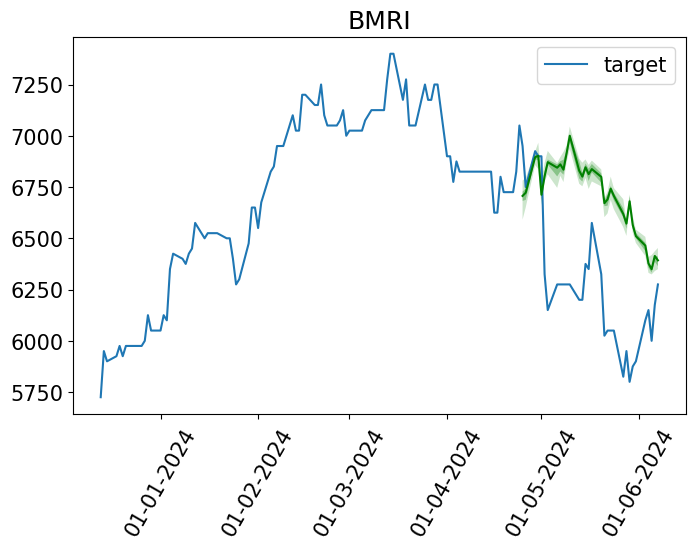

In [137]:
plotting(forecasts_fine_tuning_len_512_lr_5e_5, tss_fine_tuning_len_512_lr_5e_5)

### Get predictions with the default context length ***(1024)***

In [138]:
forecasts_fine_tuning_len_1024_lr_5e_5, tss_fine_tuning_len_1024_lr_5e_5, agg_metrics = lag_llama_fine_tuning(1024, 5e-5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 6.79023 (best 6.79023), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_566\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.36960 (best 6.36960), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_566\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.29958 (best 6.29958), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_566\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 6.24961 (best 6.24961), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_566\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 6.19774 (best 6.19774), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_566\\checkpoints\\epoch=4-step=250.ckpt' as top

In [139]:
fine_tuning_len_1024_lr_5e_5 = print_crps_fine_tuning(1024, 5e-5, agg_metrics)

Lag-Llama Fine-Tuning (1024) Lr 5e-05 CRPS: 0.0711


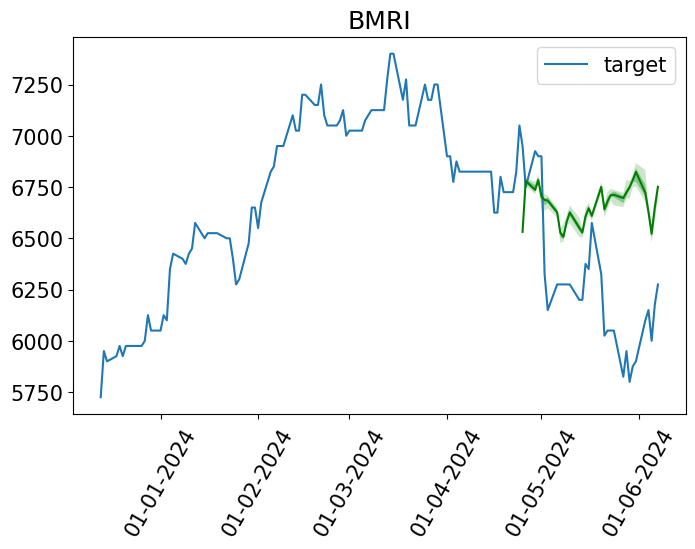

In [140]:
plotting(forecasts_fine_tuning_len_1024_lr_5e_5, tss_fine_tuning_len_1024_lr_5e_5)

# **Compared to TFT and DeepAR**

In [141]:
tft_estimator = TemporalFusionTransformerEstimator(
    prediction_length=prediction_length,
    context_length=32,
    freq="B",
    batch_size=batch_size,
    trainer_kwargs={"max_epochs": epoch}
)
deepar_estimator = DeepAREstimator(
    prediction_length=prediction_length,
    context_length=32,
    freq="B",
    batch_size=batch_size,
    trainer_kwargs={"max_epochs": epoch}
)

In [142]:
tft_predictor = tft_estimator.train(backtrain_dataset)
deepar_predictor = deepar_estimator.train(backtrain_dataset)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                           | Params | Mode  | In sizes                                                                           | Out sizes 
-------------------------------------------------------------------------------------------------------------------------------------------------------------------
0 | model | TemporalFusionTransformerModel | 109 K  | train | [[1, 32], [1, 32], [1, 1], [1, 1], [1, 64, 3], [1, 64, 0], [1, 32, 0], [1, 32, 0]] | [1, 9, 32]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------
109 K     Trainable params
0         Non-trainable params
109 K     Total params
0.439     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 4391.44824 (best 4391.44824), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_568\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 3537.42383 (best 3537.42383), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_568\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 3282.85376 (best 3282.85376), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_568\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 3094.42065 (best 3094.42065), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_568\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 2950.71851 (best 2950.71851), saving model to 'D:\\jupyter\\lag-llama-g

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 9.01614 (best 9.01614), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_570\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.74055 (best 7.74055), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_570\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.64203 (best 7.64203), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_570\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.47547 (best 7.47547), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_570\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.35236 (best 7.35236), saving model to 'D:\\jupyter\\lag-llama-git\\lag-llama\\lightning_logs\\version_570\\checkpoints\\epoch=4-step=250.ckpt' as top

In [143]:
tft_forecast_it, tft_ts_it = make_evaluation_predictions(
    dataset=backtest_dataset,
    predictor=tft_predictor,
)

deepar_forecast_it, deepar_ts_it = make_evaluation_predictions(
    dataset=backtest_dataset,
    predictor=deepar_predictor,
)

tft_forecasts = list(tft_forecast_it)
tft_tss = list(tft_ts_it)

deepar_forecasts = list(deepar_forecast_it)
deepar_tss = list(deepar_ts_it)

evaluator = Evaluator()
tft_agg_metrics, tft_ts_metrics = evaluator(iter(tft_tss), iter(tft_forecasts))
deepar_agg_metrics, deepar_ts_metrics = evaluator(iter(deepar_tss), iter(deepar_forecasts))

Running evaluation: 0it [00:00, ?it/s]The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
Running evaluation: 1it [00:00, 142.35it/s]
Running evaluation: 1it [00:00, 199.48it/s]


In [144]:
print(f"Temporal Fusion Transformer CRPS: {tft_agg_metrics['mean_wQuantileLoss']:.4f}")

Temporal Fusion Transformer CRPS: 0.2299


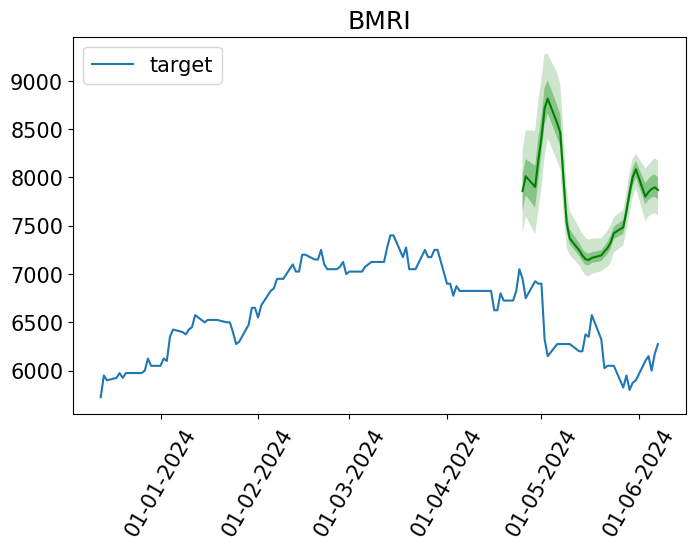

In [145]:
plotting(tft_forecasts, tft_tss)

In [146]:
print(f"DeepAR CRPS: {deepar_agg_metrics['mean_wQuantileLoss']:.4f}")

DeepAR CRPS: 0.1121


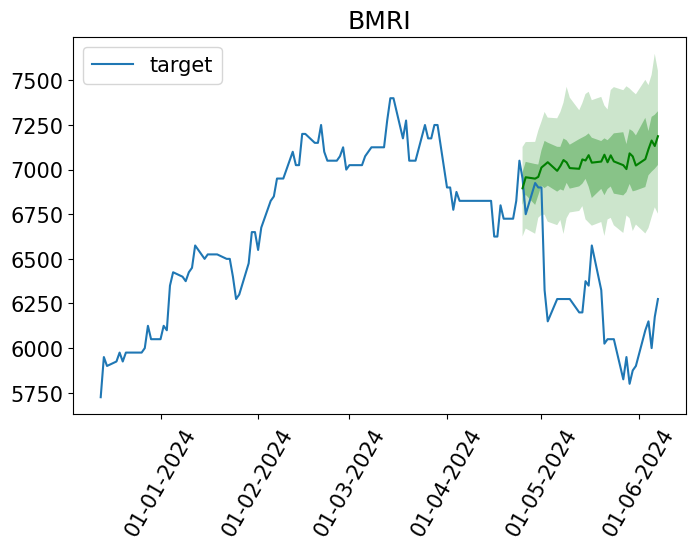

In [147]:
plotting(deepar_forecasts, deepar_tss)

# **Summary**

In [148]:
context_length = [32, 64, 128, 256, 512, 1024]
learning_rates = ['1e-2', '1e-3', '1e-4', '5e-3', '5e-4', '5e-5']

print("\n\033[1mLag-Llama Zero-Shot\033[0m")

# Lag-Llama Zero-Shot (False)
print("\n\033[1mRope scaled (False)\033[0m")
for length in context_length[:2]:
    print(f"Lag-Llama Zero-Shot ({length}) rope_scaled (False) CRPS: {globals()[f'zero_shot_len_{length}_false']:.4f}")

# Lag-Llama Zero-Shot (True)
print("\n\033[1mRope scaled (True)\033[0m")
for length in context_length[1:]:
    print(f"Lag-Llama Zero-Shot ({length}) rope_scaled (True) CRPS: {globals()[f'zero_shot_len_{length}_true']:.4f}")

# Lag-Llama Fine-Tuning
print("\n\033[1mLag-Llama Fine-Tuning\033[0m")
for lr in learning_rates:
    print(f"\n\033[1mLearning rate {lr}\033[0m")
    for length in context_length:
        variable_name = f"fine_tuning_len_{length}_lr_{lr.replace('-', '_')}"
        print(f"Lag-Llama Fine-Tuning ({length}) Lr {lr} CRPS: {globals()[variable_name]:.4f}")


print("\n\033[1mComparation Temporal Fusion Transformer (TFT) and DeepAR\033[0m")
print(f"Temporal Fusion Transformer CRPS: {tft_agg_metrics['mean_wQuantileLoss']:.4f}")
print(f"DeepAR CRPS: {deepar_agg_metrics['mean_wQuantileLoss']:.4f}")


Lag-Llama Zero-Shot

Rope scaled (False)
Lag-Llama Zero-Shot (32) rope_scaled (False) CRPS: 0.0373
Lag-Llama Zero-Shot (64) rope_scaled (False) CRPS: 0.0445

Rope scaled (True)
Lag-Llama Zero-Shot (64) rope_scaled (True) CRPS: 0.0544
Lag-Llama Zero-Shot (128) rope_scaled (True) CRPS: 0.0377
Lag-Llama Zero-Shot (256) rope_scaled (True) CRPS: 0.0466
Lag-Llama Zero-Shot (512) rope_scaled (True) CRPS: 0.1305
Lag-Llama Zero-Shot (1024) rope_scaled (True) CRPS: 0.1966

Lag-Llama Fine-Tuning

Learning rate 1e-2
Lag-Llama Fine-Tuning (32) Lr 1e-2 CRPS: 0.0930
Lag-Llama Fine-Tuning (64) Lr 1e-2 CRPS: 0.0879
Lag-Llama Fine-Tuning (128) Lr 1e-2 CRPS: 0.0637
Lag-Llama Fine-Tuning (256) Lr 1e-2 CRPS: 0.0431
Lag-Llama Fine-Tuning (512) Lr 1e-2 CRPS: 0.0461
Lag-Llama Fine-Tuning (1024) Lr 1e-2 CRPS: 0.0536

Learning rate 1e-3
Lag-Llama Fine-Tuning (32) Lr 1e-3 CRPS: 0.0880
Lag-Llama Fine-Tuning (64) Lr 1e-3 CRPS: 0.1481
Lag-Llama Fine-Tuning (128) Lr 1e-3 CRPS: 0.1429
Lag-Llama Fine-Tuning (256) Lr 

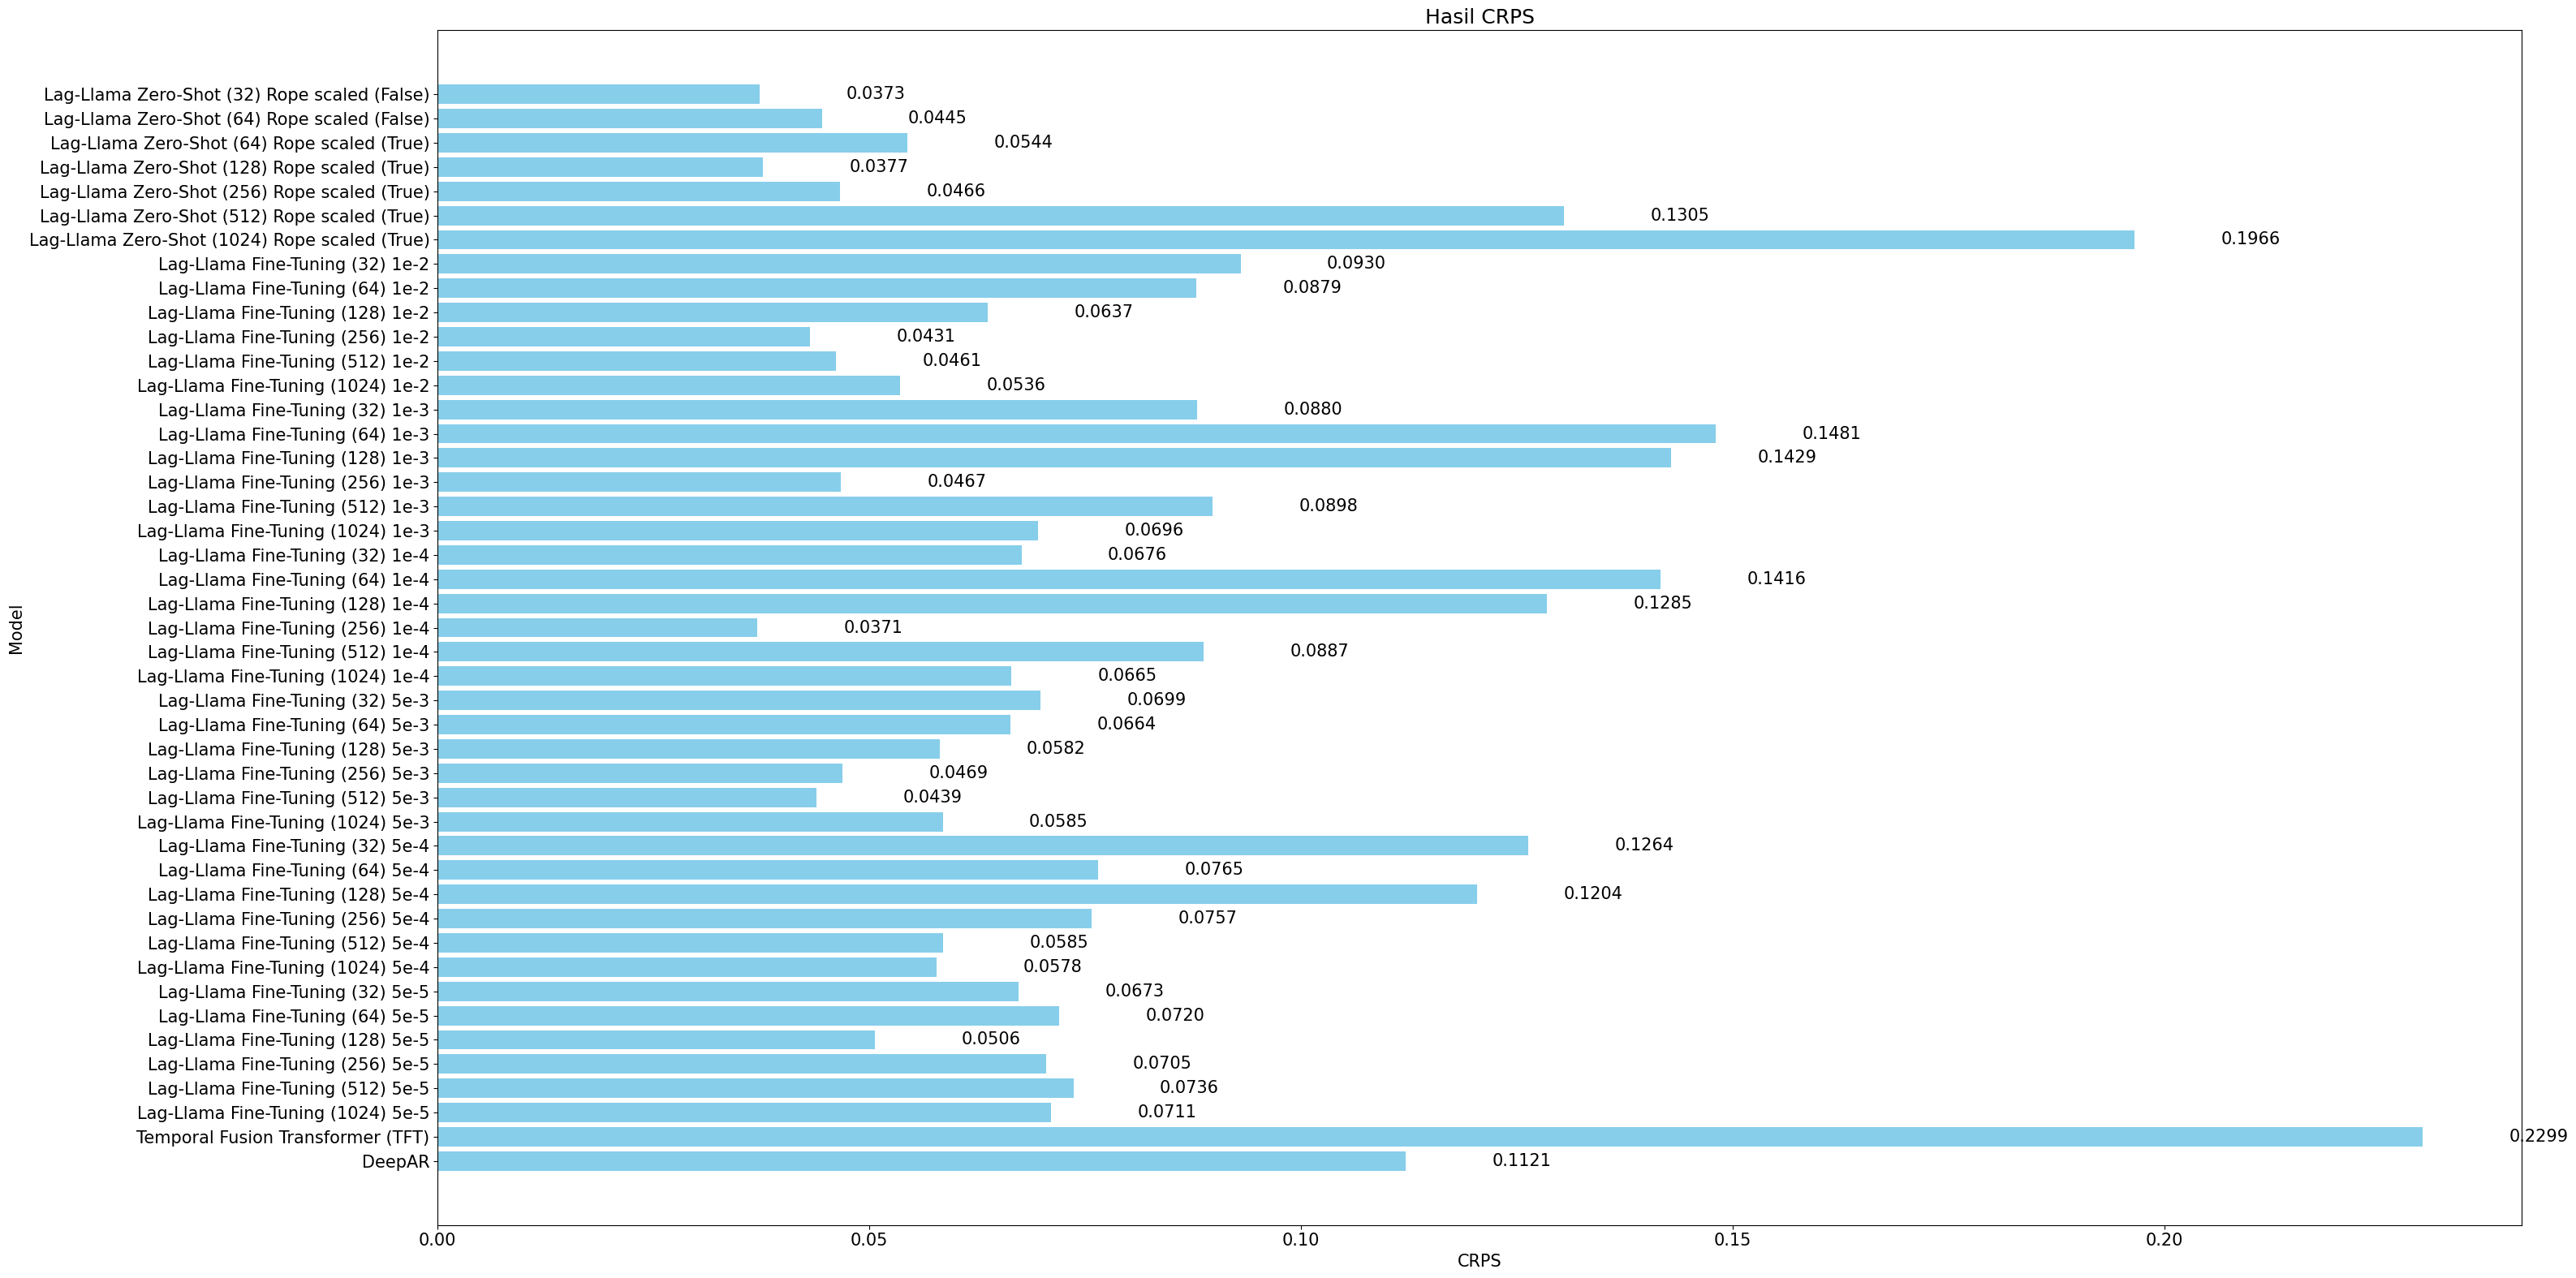

In [149]:
import matplotlib.pyplot as plt

def collect_crps_data(results):
    models, crps_values = [], []
    for model, data in results.items():
        if isinstance(data, dict):
            for sub_model, sub_data in data.items():
                for length, crps in sub_data.items():
                    models.append(f"{model} ({length}) {sub_model}")
                    crps_values.append(crps)
        else:
            models.append(model)
            crps_values.append(data)
    return models, crps_values

results = {
    "Lag-Llama Zero-Shot": {
        "Rope scaled (False)": {length: globals()[f'zero_shot_len_{length}_false'] for length in context_length[:2]},
        "Rope scaled (True)": {length: globals()[f'zero_shot_len_{length}_true'] for length in context_length[1:]}
    },
    "Lag-Llama Fine-Tuning": {
        lr: {length: globals()[f"fine_tuning_len_{length}_lr_{lr.replace('-', '_')}"] for length in context_length}
        for lr in learning_rates
    },
    "Temporal Fusion Transformer (TFT)": tft_agg_metrics['mean_wQuantileLoss'],
    "DeepAR": deepar_agg_metrics['mean_wQuantileLoss']
}

models, crps_values = collect_crps_data(results)
plt.figure(figsize=(32, 16))
bars = plt.barh(models, crps_values, color='skyblue')
plt.xlabel('CRPS')
plt.ylabel('Model')
plt.title('Hasil CRPS')
plt.gca().invert_yaxis()

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2,
             f'{width:.4f}', va='center')

plt.tight_layout()
plt.show()

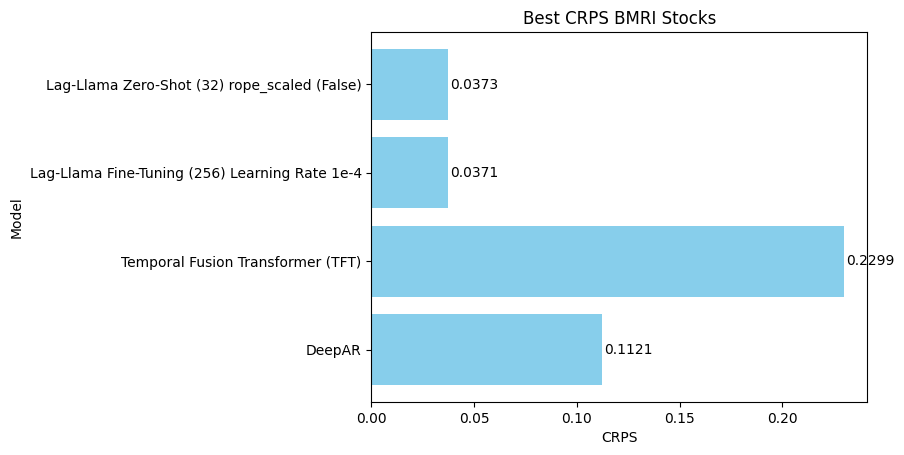

In [1]:
import matplotlib.pyplot as plt

data = {
    "Lag-Llama Zero-Shot (32) rope_scaled (False)": 0.0373,
    "Lag-Llama Fine-Tuning (256) Learning Rate 1e-4": 0.0371,
    "Temporal Fusion Transformer (TFT)": 0.2299,
    "DeepAR": 0.1121
}

models = list(data.keys())
crps_values = list(data.values())
fig, ax = plt.subplots()

bars = ax.barh(models, crps_values, color='skyblue')
plt.xlabel('CRPS')
plt.ylabel('Model')
plt.title('Best CRPS BMRI Stocks')
plt.gca().invert_yaxis()

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height() / 2, f'{width:.4f}', va='center')

plt.show()